In [168]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

import sys
sys.path.append("../include")
import hhtools

In [169]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

In [170]:
import phase_utils as pu
from importlib import reload
reload(pu)

# mapping label function
def mapping(row_names):
    # map
    key2lb = {"frs_m": "z",
              "chi": "\chi",
              "ac2p_1st": "A_1",
              "ac2p_large": "A_{large}",
              "tau_1st": "\\tau_1",
              "tau_large": "\\tau_{large}",
              "cc1p": "C",
              "leading_ratio": "\eta",
              "leading_ratio(abs)": "|\eta|",
              "dphi": "\Delta \phi"}
    
    labels = row_names.copy()
    key2lb_list = list(key2lb.keys())
    for n, key in enumerate(row_names):
        for km in key2lb_list:
            if key.find(km) > -1:
                if km == "leading_ratio" and key.find("abs") > -1:
                    continue
                
                labels[n] = labels[n].replace(km, key2lb[km])
                break
        
        if "_std" in key:
            labels[n] = labels[n].replace("_std", "")
            labels[n] = "\\sigma[%s]"%(labels[n])
            # labels[n] = labels[n]

        labels[n] = "$%s$"%(labels[n])

    return labels
        

In [171]:
# Load data
with open('./summary_data.pkl', "rb") as fp:
    post_data = pkl.load(fp)

print(post_data.keys())
print(post_data["summary_data"].keys())
print(post_data["summary_data_var"].keys())
print(post_data["summary_data"]["nr0np0"].keys())
print(post_data["summary_data_var"]["nr0np0"].keys())

dict_keys(['order', 'order_dyna', 'summary_data', 'summary_data_var', 'date'])
odict_keys(['nr0np0', 'nr0np1', 'nr0np2', 'nr0np3', 'nr0np4', 'nr0np5', 'nr0np6', 'nr1np0', 'nr1np1', 'nr1np2', 'nr1np3', 'nr1np4', 'nr1np5', 'nr1np6'])
odict_keys(['nr0np0', 'nr0np1', 'nr0np2', 'nr0np3', 'nr0np4', 'nr0np5', 'nr0np6', 'nr1np0', 'nr1np1', 'nr1np2', 'nr1np3', 'nr1np4', 'nr1np5', 'nr1np6'])
odict_keys(['frs_m', 'chi', 'cv', 'ac2p_1st', 'ac2p_large', '1/tau_1st', '1/tau_large', 'cc1p', 'leading_ratio', 'leading_ratio(abs)', 'dphi'])
odict_keys(['frs_m', 'chi', 'cv', 'ac2p_1st', 'ac2p_large', '1/tau_1st', '1/tau_large', 'cc1p', 'leading_ratio', 'leading_ratio(abs)', 'dphi'])


skipped overlap key: leading_ratio_std
skipped overlap key: leading_ratio(abs)_std
datadim: (40, 3150), nrow: 40, ncol: 3150
correcting std names target keys ['1/tau_1st_std(0)', '1/tau_1st_std(1)', '1/tau_1st_std(2)', '1/tau_large_std(0)', '1/tau_large_std(1)', '1/tau_large_std(2)']


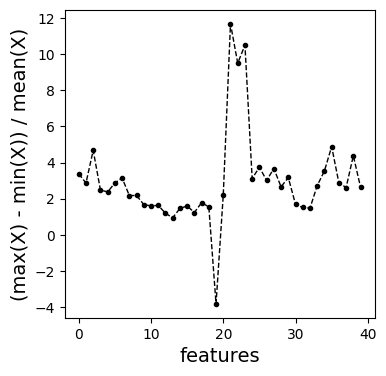

In [172]:
align_data, row_names, col_names = pu.concat_data(post_data, key_to_rm=["cv", "dphi"], include_std=True, show_mm_scale=True)

skipped overlap key: leading_ratio_std
skipped overlap key: leading_ratio(abs)_std
datadim: (40, 3150), nrow: 40, ncol: 3150
correcting std names target keys ['1/tau_1st_std(0)', '1/tau_1st_std(1)', '1/tau_1st_std(2)', '1/tau_large_std(0)', '1/tau_large_std(1)', '1/tau_large_std(2)']
(40, 3150)


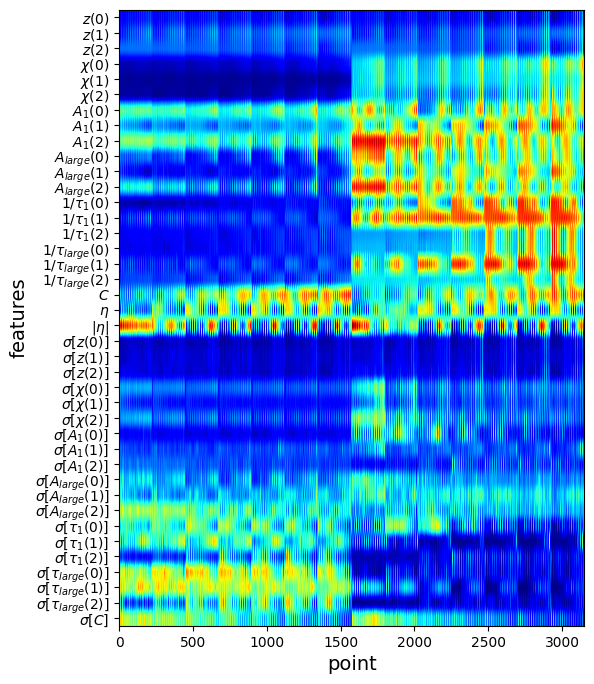

In [173]:
align_data, row_names, col_names = pu.concat_data(post_data, key_to_rm=["cv", "dphi"], include_std=True)
print(align_data.shape)

row_labels = mapping(row_names)

plt.figure(figsize=(6, 8))
plt.imshow(align_data, aspect="auto", cmap="jet")
plt.xlabel("point", fontsize=14)
plt.ylabel("features", fontsize=14)
plt.yticks(np.arange(0, len(row_names), 1), labels=row_labels[::1])
plt.show()

# Dimension reduction

## Test

### Generate test data set

1.734723475976807e-16


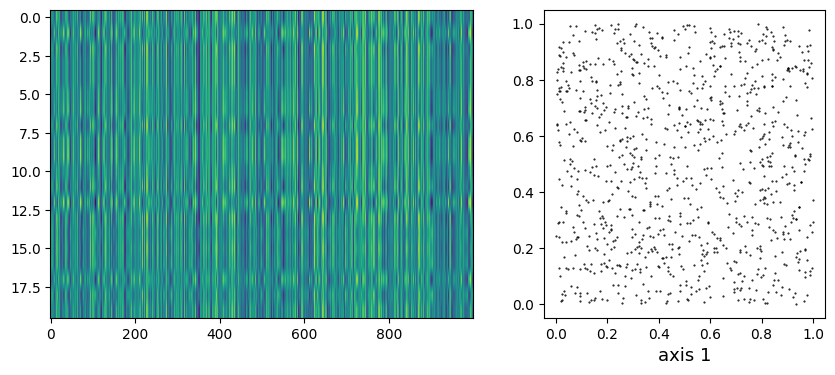

In [9]:
ndim = 20
def gen_rd_unit(ndim):
    vec = np.random.uniform(low=0, high=1, size=ndim)
    return vec / np.sqrt(np.sum(vec**2))

np.random.seed(10)

base1 = gen_rd_unit(ndim)
base2 = gen_rd_unit(ndim)
# orthogonalize
base2 = base2 - np.dot(base1, base2) * base1
print(np.dot(base1, base2))

ndata = 1000
data_ldim = np.random.uniform(size=(2, ndata))
# data_ldim = np.random.randn(2, ndata)
pdata = np.zeros([ndim, ndata])
for n in range(ndata):
    pdata[:, n] = data_ldim[0, n] * base1 + data_ldim[1, n] * base2

# min-max scaling
xmin = np.min(pdata, axis=1)
xmax = np.max(pdata, axis=1)
pdata = (pdata - xmin[:, np.newaxis]) / (xmax - xmin)[:, np.newaxis]

fig, axs = plt.subplots(1,2, figsize=(10, 4), gridspec_kw={"width_ratios": [0.6, 0.4]})
plt.axes(axs[0])
plt.imshow(pdata, aspect="auto")

plt.axes(axs[1])
plt.plot(data_ldim[0], data_ldim[1], 'k.', ms=1)
plt.xlabel("axis 0", fontsize=13)
plt.xlabel("axis 1", fontsize=13)

plt.show()


### PCA

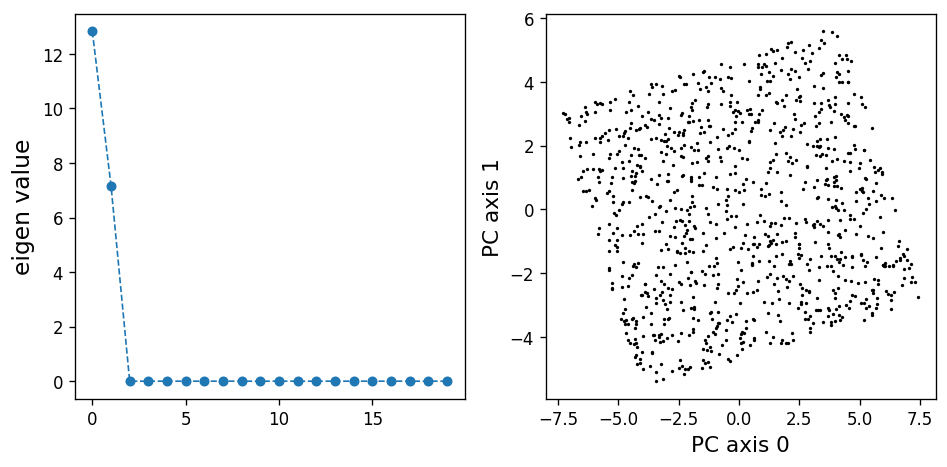

In [13]:
# test with pca
eigval, eigvec, pca_data, cov_mat = pu.pca(pdata)

plt.figure(dpi=120, figsize=(8, 4))
plt.subplot(121)
plt.plot(eigval, '.--', lw=1, ms=10)
plt.ylabel("eigen value", fontsize=14)

plt.subplot(122)
pdata_r = np.dot(pca_data.T, eigvec[:, :2])
plt.scatter(pdata_r[:, 0], pdata_r[:, 1], s=1, c='k')
plt.xlabel("PC axis 0", fontsize=13)
plt.ylabel("PC axis 1", fontsize=13)

plt.tight_layout()
plt.show()


### t-SNE

In [14]:
# Train the mdoel
model = TSNE(n_components=2, init="pca")
tsne_data = model.fit_transform(pdata.T)

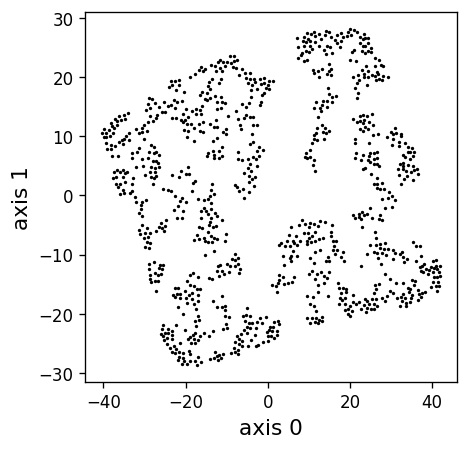

In [15]:
plt.figure(dpi=120, figsize=(4, 4))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c='k', s=1)
plt.xlabel("axis 0", fontsize=13)
plt.ylabel("axis 1", fontsize=13)
plt.show()

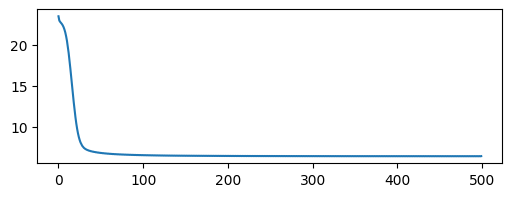

6.4377575221828955
std(0) [0.29128356 0.29590731]
std(0) [0.71589669 0.8699654 ]


In [16]:
Wopt, Hopt, df_hist = pu.nnmf_simple(pdata, n_features=2, nitr=500, nre=100)

plt.figure(figsize=(6, 2))
plt.plot(df_hist)
plt.show()

df_hist[df_hist == -1] = np.nan
print(np.nanmin(df_hist))
print("std(0)", np.std(data_ldim, axis=1))
print("std(0)", np.std(Hopt, axis=1))

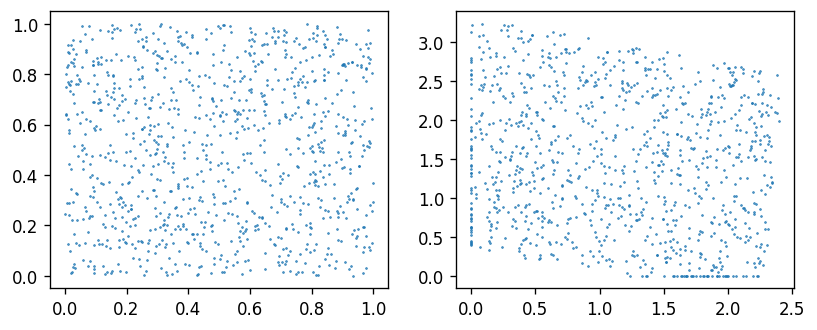

[0.29128356 0.29590731]
[0.71589669 0.8699654 ]


In [14]:
plt.figure(figsize=(8, 3), dpi=120)

plt.subplot(121)
plt.plot(data_ldim[0, :], data_ldim[1, :], '.', lw=1, ms=1)

plt.subplot(122)
plt.plot(Hopt[0, :], Hopt[1, :], '.', lw=1, ms=1)
plt.show()

print(np.std(data_ldim, axis=1))
print(np.std(Hopt, axis=1))

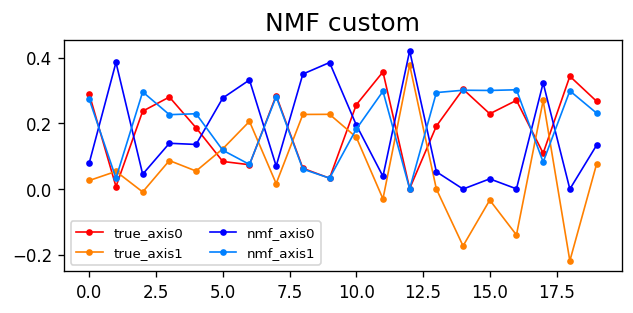

In [15]:
states = np.arange(ndim)
plt.figure(dpi=120, figsize=(6, 2.5))
plt.plot(states, base1, '.-', c=[1, 0, 0], label="true_axis0", lw=1)
plt.plot(states, base2, '.-', c=[1, 0.5, 0], label="true_axis1", lw=1)

plt.plot(states, Wopt[:,0], '.-', c=[0, 0, 1], label="nmf_axis0", lw=1)
plt.plot(states, Wopt[:,1], '.-', c=[0, 0.5, 1], label="nmf_axis1", lw=1)

plt.title("NMF custom", fontsize=15)
plt.legend(fontsize=8, ncol=2, facecolor="none")
plt.show()

### NNMF-sklearn version

In [15]:
nmf_estimator = NMF(n_components=2, tol=1e-5, 
                    alpha_W=1e-3, alpha_H=1e-3, l1_ratio=0,
                    init=None, max_iter=1000)
nmf_estimator.fit(pdata.T)
data_low_r = nmf_estimator.transform(pdata.T).T

# noramlize
W = nmf_estimator.components_.T
wc = np.sqrt(np.sum(W**2, axis=0))
W = W / wc[np.newaxis, :]

data_low_r = data_low_r * wc[:, np.newaxis]
pdata_r = np.dot(W, data_low_r)

df = np.sqrt(np.sum((pdata - pdata_r)**2))
print("del F = %.2f"%(df))

del F = 4.30


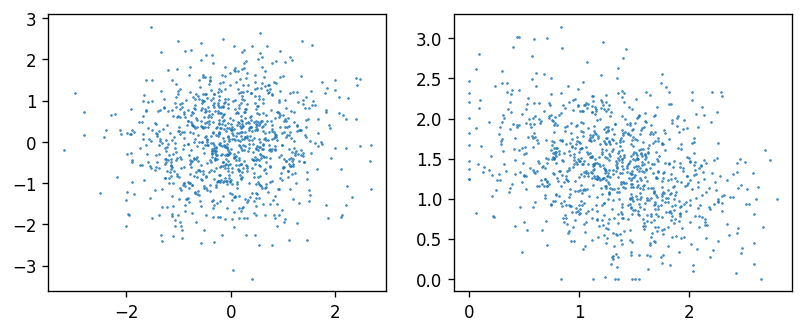

[0.93577628 0.99207497]
[0.54833118 0.55543877]


In [16]:
xy = nmf_estimator.components_
plt.figure(figsize=(8, 3), dpi=120)

plt.subplot(121)
plt.plot(data_ldim[0, :], data_ldim[1, :], '.', lw=1, ms=1)

plt.subplot(122)
plt.plot(data_low_r[0, :], data_low_r[1, :], '.', lw=1, ms=1)
plt.show()

print(np.std(data_ldim, axis=1))
print(np.std(data_low_r, axis=1))


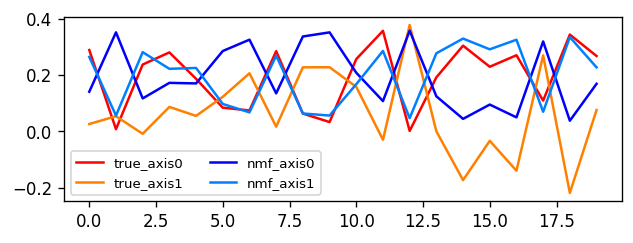

In [17]:
states = np.arange(ndim)
plt.figure(dpi=120, figsize=(6, 2))
plt.plot(states, base1, c=[1, 0, 0], label="true_axis0")
plt.plot(states, base2, c=[1, 0.5, 0], label="true_axis1")

plt.plot(states, W[:,0], c=[0, 0, 1], label="nmf_axis0")
plt.plot(states, W[:,1], c=[0, 0.5, 1], label="nmf_axis1")

plt.legend(fontsize=8, ncol=2, facecolor="none")
plt.show()

## Real data

### Simple linear method: PCA

In [18]:
align_data, row_names, col_names = pu.concat_data(post_data, key_to_rm=["cv", "dphi"])
eigval, eigvec, pca_data, cov_mat = pu.pca(align_data)

print(row_names)

(21, 3150)
nrow: 21, ncol: 3150
inversing target keys: ['tau_1st(0)', 'tau_1st(1)', 'tau_1st(2)', 'tau_large(0)', 'tau_large(1)', 'tau_large(2)']
['frs_m(0)', 'frs_m(1)', 'frs_m(2)', 'chi(0)', 'chi(1)', 'chi(2)', 'ac2p_1st(0)', 'ac2p_1st(1)', 'ac2p_1st(2)', 'ac2p_large(0)', 'ac2p_large(1)', 'ac2p_large(2)', 'tau_1st(0)', 'tau_1st(1)', 'tau_1st(2)', 'tau_large(0)', 'tau_large(1)', 'tau_large(2)', 'cc1p', 'leading_ratio', 'leading_ratio(abs)']


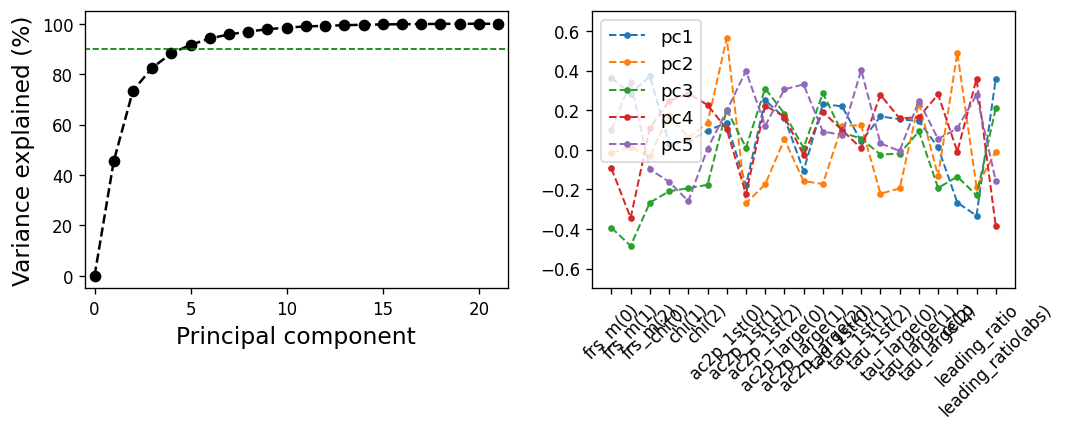

In [19]:
# Variance explained
explained = np.cumsum(eigval)
explained = explained / explained[-1] * 100
explained = np.concatenate([[0], explained])

plt.figure(dpi=120, figsize=(10, 3))

plt.subplot(121)
plt.plot(explained, "k.--", ms=12)
plt.plot([-1, len(explained)+1], [90]*2, 'g--', lw=1)
plt.xlim([-0.5, len(explained)-0.5])
plt.xlabel("Principal component", fontsize=14)
plt.ylabel("Variance explained (%)", fontsize=14)

plt.subplot(122)
ind_pca = 0
while explained[ind_pca] < 90:
    ind_pca += 1

for n in range(1, ind_pca+1):
    plt.plot(eigvec[:, n], '.--', lw=1.2, label="pc%d"%(n))
plt.ylim([-0.7, 0.7])
plt.legend(fontsize=11, loc="upper left")
plt.xticks(np.arange(len(eigvec)), labels=row_names, rotation=45)

plt.show()

pc_axis = eigvec[:, :ind_pca]
projected_data = np.dot(pca_data.T, pc_axis)

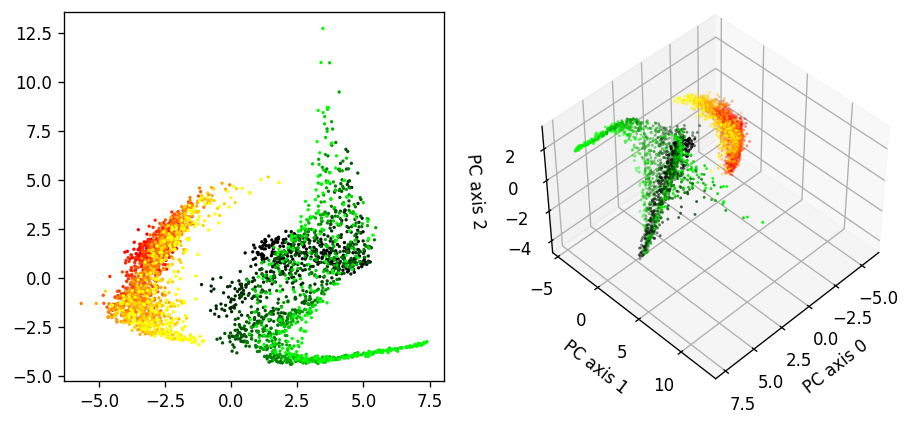

In [21]:
cs_default = pu.default_colors(col_names)
fig = plt.figure(figsize=(9, 4), dpi=120)

ax1 = plt.subplot(121)
plt.scatter(projected_data[:, 0], projected_data[:, 1], s=1, c=cs_default)

ax2 = fig.add_subplot(122, projection="3d")
scatter_obj = ax2.scatter(projected_data[:, 0], projected_data[:, 1], projected_data[:, 2], s=3, c=cs_default, edgecolor='none')
ax2.set_xlabel("PC axis 0")
ax2.set_ylabel("PC axis 1")
ax2.set_zlabel("PC axis 2")
ax2.view_init(45, 45)

plt.show()

### t-sne

In [22]:
# Train the mdoel
align_data, row_names, col_names = pu.concat_data(post_data, key_to_rm=["cv", "dphi"])

model = TSNE(n_components=2, init="pca")
data_embedded = model.fit_transform(align_data.T)

(21, 3150)
nrow: 21, ncol: 3150
inversing target keys: ['tau_1st(0)', 'tau_1st(1)', 'tau_1st(2)', 'tau_large(0)', 'tau_large(1)', 'tau_large(2)']


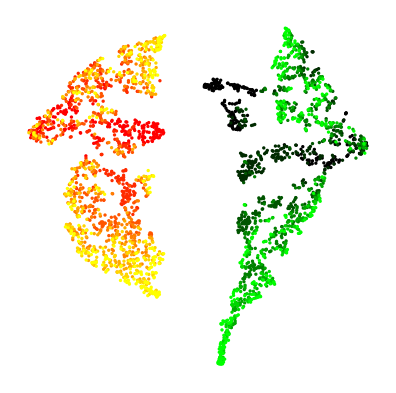

In [23]:
cs = pu.default_colors(col_names)

plt.figure(figsize=(4, 4), dpi=120)
plt.scatter(data_embedded[:, 0], data_embedded[:, 1], s=1, c=cs)
plt.axis("off")
plt.show()

### NNMF

In [18]:
align_data, row_names, col_names = pu.concat_data(post_data, key_to_rm=["cv", "dphi"])
print(align_data.shape)

(21, 3150)
nrow: 21, ncol: 3150
inversing target keys: ['tau_1st(0)', 'tau_1st(1)', 'tau_1st(2)', 'tau_large(0)', 'tau_large(1)', 'tau_large(2)']
(21, 3150)


In [70]:
np.random.seed(100)
Wopt, Hopt, df_hist = pu.nnmf_simple(align_data, n_features=3, nitr=500, nre=100)

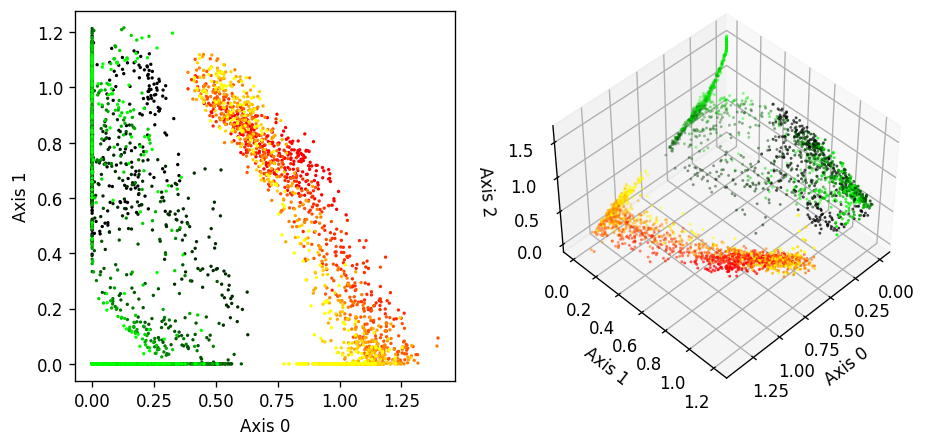

In [71]:
cs_default = pu.default_colors(col_names)
fig = plt.figure(figsize=(9, 4), dpi=120)

ax1 = plt.subplot(121)
plt.scatter(Hopt[0], Hopt[1], s=1, c=cs_default)
plt.xlabel("Axis 0")
plt.ylabel("Axis 1")

ax2 = fig.add_subplot(122, projection="3d")
scatter_obj = ax2.scatter(Hopt[0], Hopt[1], Hopt[2], s=3, c=cs_default, edgecolor='none')
ax2.set_xlabel("Axis 0")
ax2.set_ylabel("Axis 1")
ax2.set_zlabel("Axis 2")
ax2.view_init(45, 45)

plt.show()

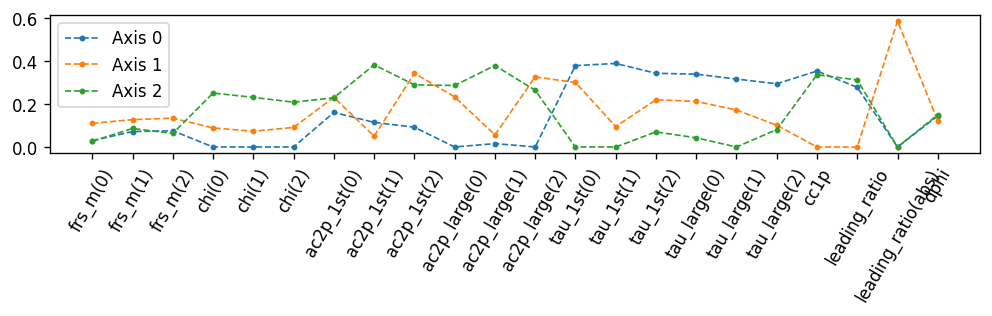

In [72]:
xs = np.arange(len(Wopt))
plt.figure(dpi=120, figsize=(10, 1.5))
lbs = ["Axis 0", "Axis 1", "Axis 2"]
for n in range(Wopt.shape[1]):
    plt.plot(Wopt[:, n], '.--', lw=1, ms=5, label=lbs[n])
plt.xticks(xs, labels=row_names, rotation=60)
plt.legend(fontsize=14)
plt.legend()
plt.show()

# Clustering

## Hierarchical clustering

In [25]:
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
linkage_data = linkage(Hopt.T, method='centroid', metric='euclidean')

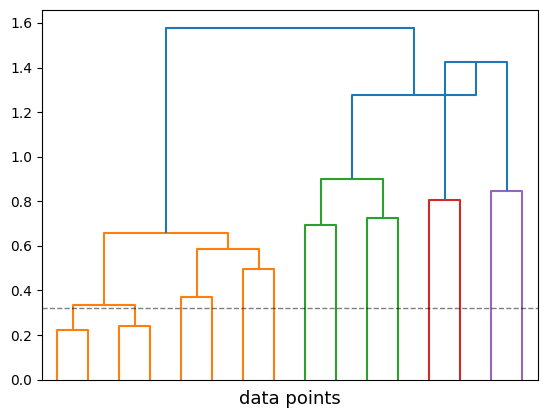

29


In [30]:
cut_height = 0.32

plt.figure()
dendro = dendrogram(linkage_data, 3, no_labels=True, truncate_mode="level")
xl = plt.xlim()
plt.plot(xl, [cut_height]*2, 'k--', lw=1, alpha=0.5)
plt.xlabel("data points", fontsize=13)
plt.show()

cluster_ids = cut_tree(linkage_data, height=cut_height)
print(len(np.unique(cluster_ids)))

# plt.show()

In [33]:
Hopt.shape

(2, 1000)

In [31]:
sval, scoeff = pu.get_silhouette_scores(Hopt, cluster_ids)
reordered_data, id_order, bds = pu.reorder_data(align_data, cluster_ids, sval)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 3150 but corresponding boolean dimension is 1000

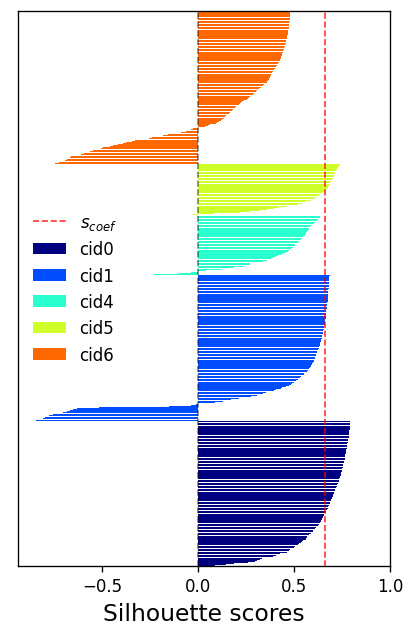

In [100]:
plt.figure(dpi=120, figsize=(4, 6))
draw_silhouette(sval, cluster_ids, scoeff=scoeff)

plt.show()

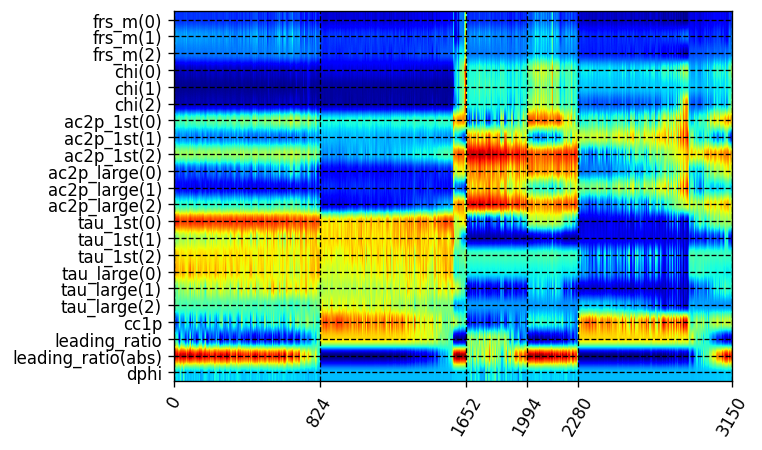

In [101]:
# draw sval in ordered manner

plt.figure(figsize=(6, 4), dpi=120)
plt.imshow(reordered_data, aspect='auto', cmap="jet")
plt.xticks([0] + bds, rotation=60)
plt.yticks(np.arange(len(row_names)), labels=row_names)
plt.grid(True, lw=0.8, c='k', linestyle='--')
plt.show()

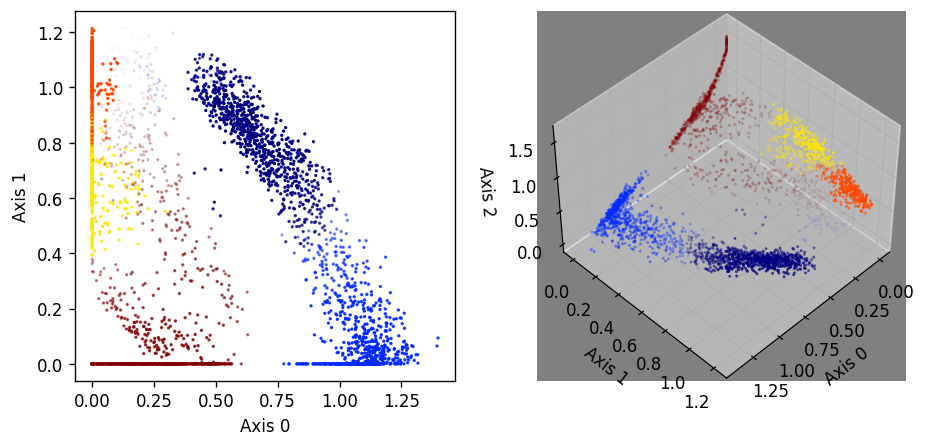

In [129]:
palette = get_palette("jet")

tmp_cids = cluster_ids[:, 0]
cmap = palette(tmp_cids / max(tmp_cids))
alpha = (sval - np.min(sval)) / (np.max(sval) - np.min(sval))
cmap[:, 3] = alpha

fig = plt.figure(figsize=(9, 4), dpi=120)

ax1 = plt.subplot(121)
plt.scatter(Hopt[0], Hopt[1], s=1, c=cmap)
plt.xlabel("Axis 0")
plt.ylabel("Axis 1")

ax2 = fig.add_subplot(122, projection="3d")
ax2.set_facecolor("gray")

scatter_obj = ax2.scatter(Hopt[0], Hopt[1], Hopt[2], s=3, c=cmap, edgecolor='none')
ax2.set_xlabel("Axis 0")
ax2.set_ylabel("Axis 1")
ax2.set_zlabel("Axis 2")
ax2.view_init(45, 45)

plt.show()

In [66]:
from sklearn.cluster import KMeans


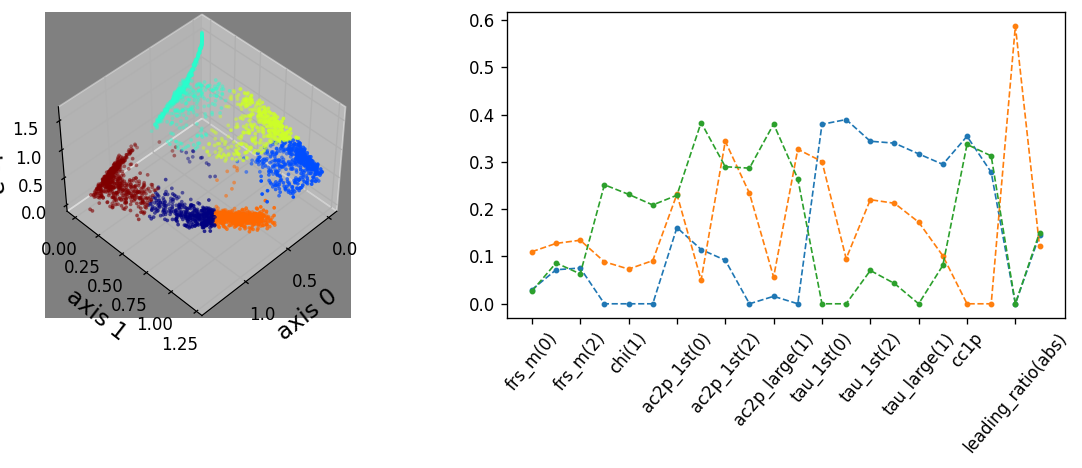

0-0 dot: 1.00
0-1 dot: 0.50
0-2 dot: 0.42
1-1 dot: 1.00
1-2 dot: 0.48
2-2 dot: 1.00


In [130]:
num_c = 6
km_obj_nnmf = KMeans(n_clusters=num_c, init="k-means++", n_init="auto")
km_obj_nnmf.fit(Hopt.T)
cluster_ids_nnmf = km_obj_nnmf.predict(Hopt.T)

fig = plt.figure(dpi=120, figsize=(10, 4))
ax = fig.add_subplot(121, projection="3d")
ax.set_facecolor("gray")
ax.scatter(Hopt[0], Hopt[1], Hopt[2], c=cluster_ids_nnmf, s=5, cmap="jet", edgecolor="none")
ax.view_init(45, 45)
ax.set_xlabel("axis 0", fontsize=14)
ax.set_ylabel("axis 1", fontsize=14)
ax.set_zlabel("axis 2", fontsize=14)


ax2 = fig.add_subplot(122)
plt.plot(Wopt, '.--', lw=1., ms=5)
xt = np.arange(0, 21, 2)
plt.xticks(xt, labels=[row_names[i] for i in xt], rotation=50)

plt.tight_layout()
plt.show()

for i in range(Wopt.shape[1]):
    for j in range(i, Wopt.shape[1]):
        print("%d-%d dot: %.2f"%(i, j, np.dot(Wopt[:, i], Wopt[:, j])))


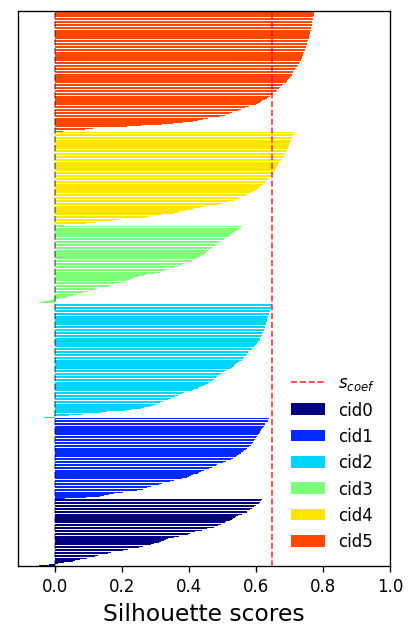

In [131]:
sval, scoeff = get_silhouette_scores(Hopt, cluster_ids_nnmf)
reordered_data, id_sort, bds = reorder_data(align_data, cluster_ids_nnmf, sval)

plt.figure(dpi=120, figsize=(4, 6))
draw_silhouette(sval, cluster_ids_nnmf, scoeff=scoeff)
plt.show()

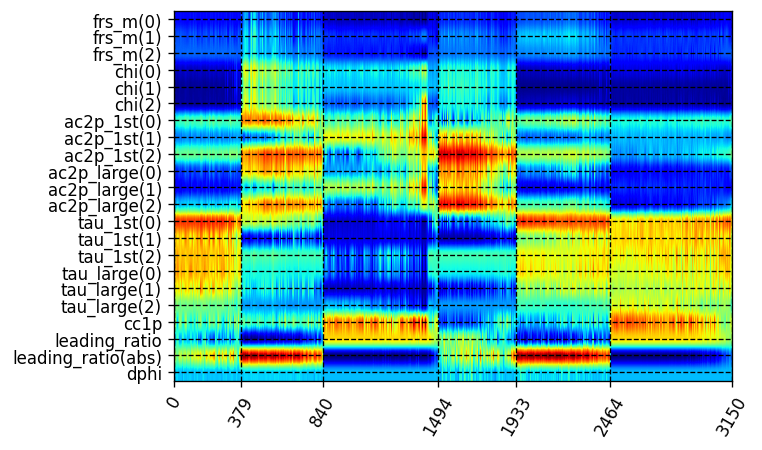

In [132]:
# draw sval in ordered manner
plt.figure(figsize=(6, 4), dpi=120)
plt.imshow(reordered_data, aspect='auto', cmap="jet")
plt.xticks([0] + bds, rotation=60)
plt.yticks(np.arange(len(row_names)), labels=row_names)
plt.grid(True, lw=0.8, c='k', linestyle='--')
plt.show()

## Clustering with full rank data

In [174]:
def set_seed(seed):
    np.random.seed(seed)

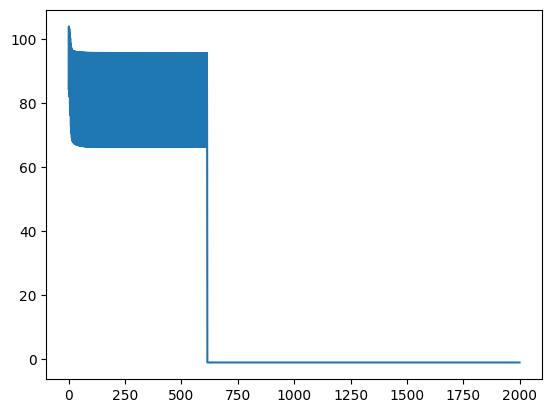

In [175]:
set_seed(200)
Wopt, Hopt, df_hist = pu.nnmf_simple(align_data, n_features=3, tol=1e-4, n_repeat=50, nitr=2000)

plt.figure()
plt.plot(df_hist)
plt.show()

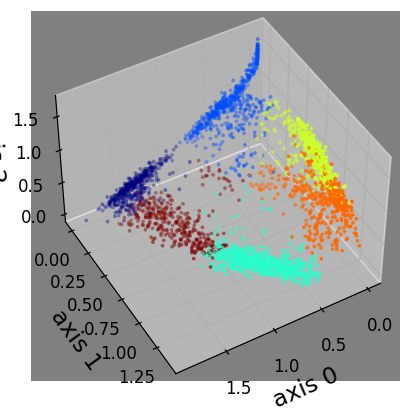

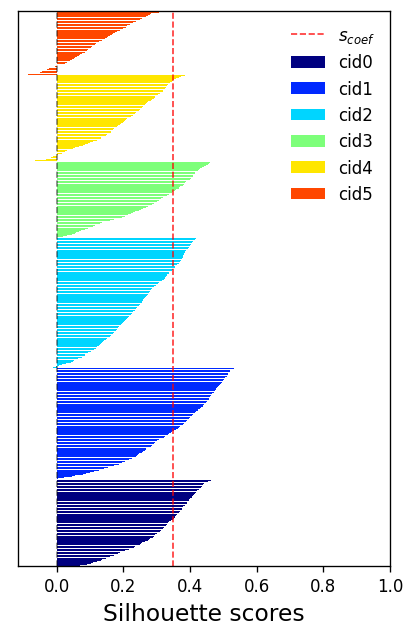

In [127]:
set_seed(100)

# use full rank data
num_c = 6
km_obj = KMeans(n_clusters=num_c, init="k-means++", n_init="auto")
km_obj.fit(align_data.T)
cluster_ids = km_obj.predict(align_data.T)

sval, scoeff = pu.get_silhouette_scores(align_data, cluster_ids)
reordered_data, id_sort, bds = pu.reorder_data(align_data, cluster_ids, sval)

palette = pu.get_palette("jet")
tmp_cids = cluster_ids
cmap = palette(tmp_cids / max(tmp_cids))

fig = plt.figure(dpi=120, figsize=(10, 4))
ax = fig.add_subplot(121, projection="3d")
ax.set_facecolor("gray")
ax.scatter(Hopt[0], Hopt[1], Hopt[2], c=cmap, s=5, edgecolor="none")
ax.view_init(45, 60, 0)
ax.set_xlabel("axis 0", fontsize=14)
ax.set_ylabel("axis 1", fontsize=14)
ax.set_zlabel("axis 2", fontsize=14)

plt.figure(dpi=120, figsize=(4, 6))
pu.draw_silhouette(sval, cluster_ids, scoeff=scoeff)
plt.show()

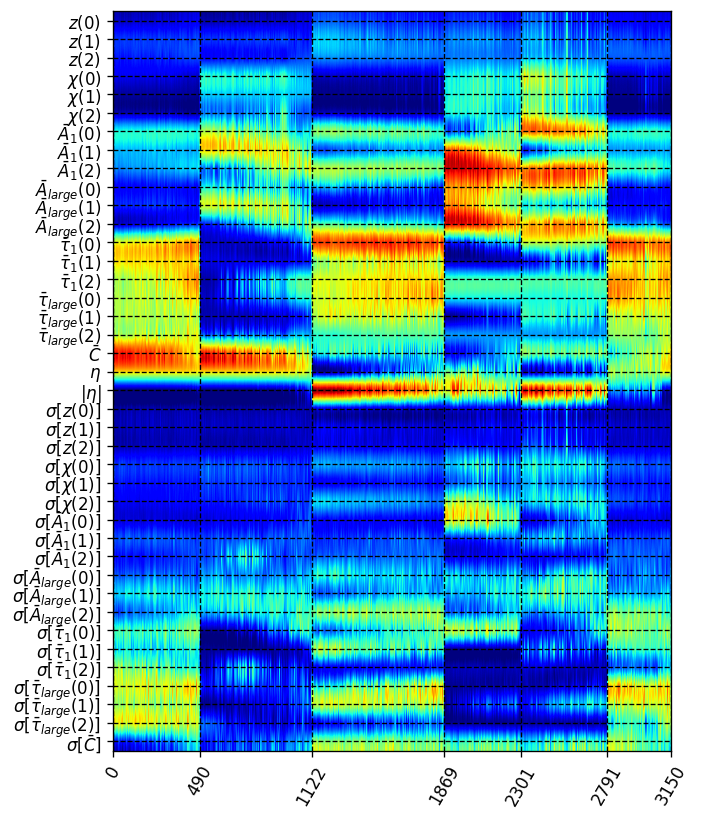

In [285]:
row_labels = mapping(row_names)

# draw sval in ordered manner
plt.figure(figsize=(6, 8), dpi=120)
plt.imshow(reordered_data, aspect='auto', cmap="jet", interpolation="spline16")
# hhtools.imshow_xy(reordered_data, cmap="jet", interpolation="bilinear")
plt.xticks([0] + bds, rotation=60)
plt.yticks(np.arange(len(row_names)), labels=row_labels)
plt.grid(True, lw=0.8, c='k', linestyle='--')
plt.show()

### K-means clustering 

In [88]:
## Quantization
set_seed(200)

num_clusters = np.arange(2, 24)
km_scores = []
s_scores = []
s_vals = []

align_data, row_names, col_names = pu.concat_data(post_data, key_to_rm=["cv", "dphi"], include_std=True, show_mm_scale=False)

km_obj_set = []
for nc in num_clusters:
    km_obj = KMeans(n_clusters=nc, init="k-means++", n_init="auto")
    km_obj.fit(align_data.T)
    labels = km_obj.predict(align_data.T)
    sval, scoeff = pu.get_silhouette_scores(align_data, labels)

    km_scores.append(km_obj.inertia_)
    s_scores.append(scoeff)
    s_vals.append(sval)

    km_obj_set.append(km_obj)

skipped overlap key: leading_ratio_std
skipped overlap key: leading_ratio(abs)_std
datadim: (40, 3150), nrow: 40, ncol: 3150
correcting std names target keys ['1/tau_1st_std(0)', '1/tau_1st_std(1)', '1/tau_1st_std(2)', '1/tau_large_std(0)', '1/tau_large_std(1)', '1/tau_large_std(2)']


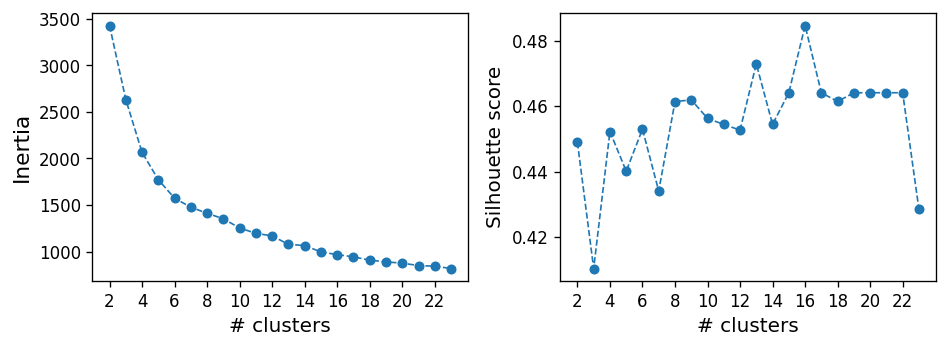

In [89]:
fig, axs = plt.subplots(1, 2, dpi=120, figsize=(8, 3))
plt.axes(axs[0])
plt.plot(num_clusters, km_scores, '.--', ms=10, lw=1)
plt.ylabel("Inertia", fontsize=13)
plt.xticks(num_clusters[::2])
plt.xlabel("# clusters", fontsize=12)

plt.axes(axs[1])
plt.plot(num_clusters, s_scores, '.--', ms=10, lw=1)
plt.ylabel("Silhouette score", fontsize=12)
plt.xticks(num_clusters[::2])
plt.xlabel("# clusters", fontsize=12)

plt.tight_layout()
plt.show()

In [90]:
def construct_square_image(prefix, data, col_names, ld=15):
    # data (-1, N)
    if ld is None:
        pass

    im = np.zeros([ld, ld])
    is_valid = False
    for n, cn in enumerate(col_names):
        if prefix in cn[0]:
            nr, nc = cn[1], cn[2]
            im[nr, nc] = data[:, n]
            is_valid = True
    
    if not is_valid:
        raise ValueError("%s does not exist in col_names"%(prefix))

    return im

11


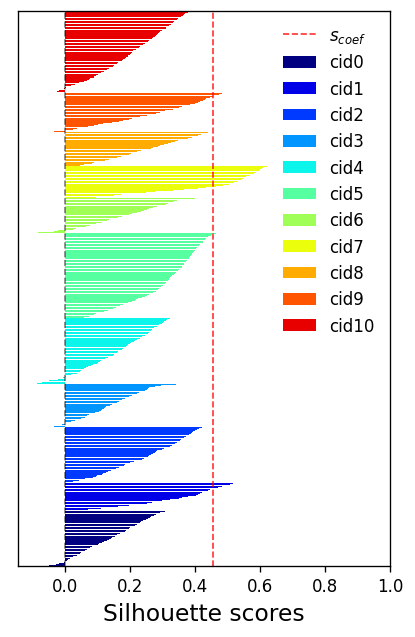

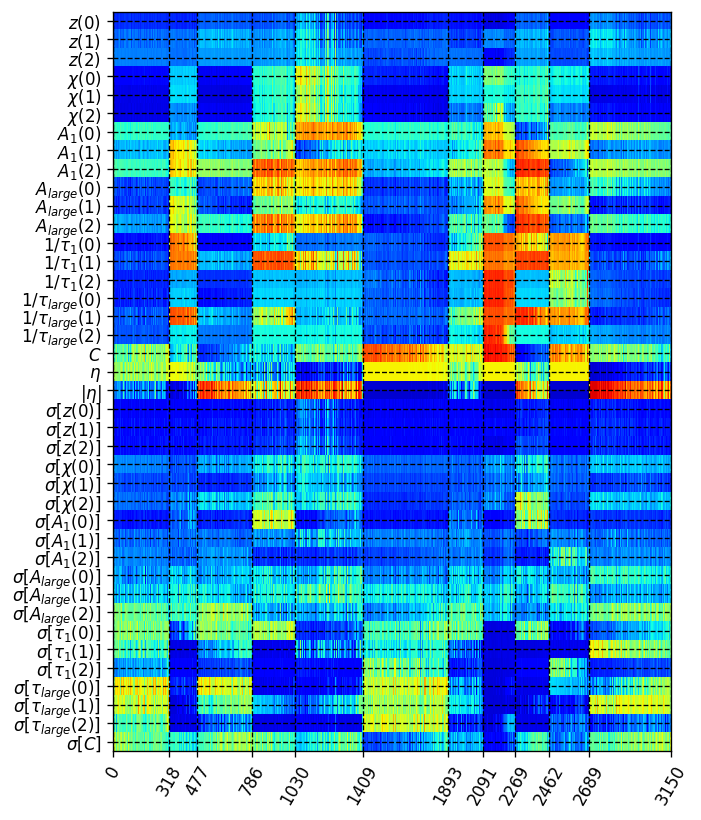

In [91]:
nc = 9
print(num_clusters[nc])
cluster_ids = km_obj_set[nc].predict(align_data.T)

reordered_data, id_sort, bds = pu.reorder_data(align_data, cluster_ids, s_vals[nc])

plt.figure(dpi=120, figsize=(4, 6))
pu.draw_silhouette(s_vals[nc], cluster_ids, scoeff=s_scores[nc])
plt.show()

# draw sval in ordered manner
sdata = reordered_data.copy()
for n in range(sdata.shape[0]):
    sdata[n] = savgol_filter(sdata[n], 10, 2)

plt.figure(figsize=(6, 8), dpi=120)
plt.imshow(sdata, aspect='auto', cmap="jet", interpolation="none")
plt.xticks([0] + bds, rotation=60)
plt.yticks(np.arange(len(row_names)), labels=mapping(row_names))
plt.grid(True, lw=0.8, c='k', linestyle='--')
plt.show()

tag = "nr1np5"
# tag = "nr1np5"s
alpha = s_vals[nc]
alpha = (alpha - np.min(alpha)) / (np.max(alpha) - np.min(alpha))

im = construct_square_image(tag, cluster_ids[np.newaxis, :], col_names)
# alpha = construct_square_image(tag, alpha[np.newaxis, :], col_names)

### Purify data

skipped overlap key: leading_ratio_std
skipped overlap key: leading_ratio(abs)_std
datadim: (34, 3150), nrow: 34, ncol: 3150
correcting std names target keys ['1/tau_1st_std(0)', '1/tau_1st_std(1)', '1/tau_1st_std(2)', '1/tau_large_std(0)', '1/tau_large_std(1)', '1/tau_large_std(2)']
Purify more...
tau_large_std(2)
ac2p_large_std(0)
ac2p_1st_std(2)
ac2p_1st_std(1)
ac2p_1st_std(0)
chi_std(2)
chi_std(1)
chi_std(0)


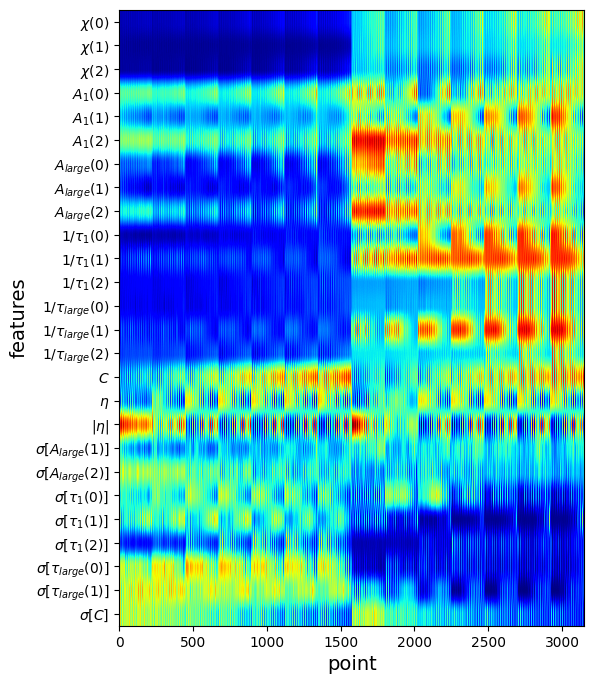

In [93]:
align_data_p, row_names_p, col_names_p = pu.concat_data(post_data, key_to_rm=["frs_m", "cv", "dphi"], include_std=True)

# remove std data
print("Purify more...")
nid_set = np.sort([18, 19, 20, 21, 22, 23, 24, 32])[::-1]
for nid in nid_set:
    print(row_names_p[nid])
    align_data_p = np.delete(align_data_p, nid, 0)
    del(row_names_p[nid])

row_labels_p = mapping(row_names_p)

plt.figure(figsize=(6, 8))
plt.imshow(align_data_p, aspect="auto", cmap="jet")
plt.xlabel("point", fontsize=14)
plt.ylabel("features", fontsize=14)
plt.yticks(np.arange(0, len(row_names_p), 1), labels=row_labels_p[::1])
plt.show()

In [113]:
set_seed(200)

num_c = 9

km_obj = KMeans(n_clusters=num_c, init="k-means++", n_init="auto")
km_obj.fit(align_data_p.T)
cluster_id_p = km_obj.predict(align_data_p.T)

sval_p, scoeff_p = pu.get_silhouette_scores(align_data_p, cluster_id_p)
reordered_data, id_sort, bds = pu.reorder_data(align_data_p, cluster_id_p, sval_p)

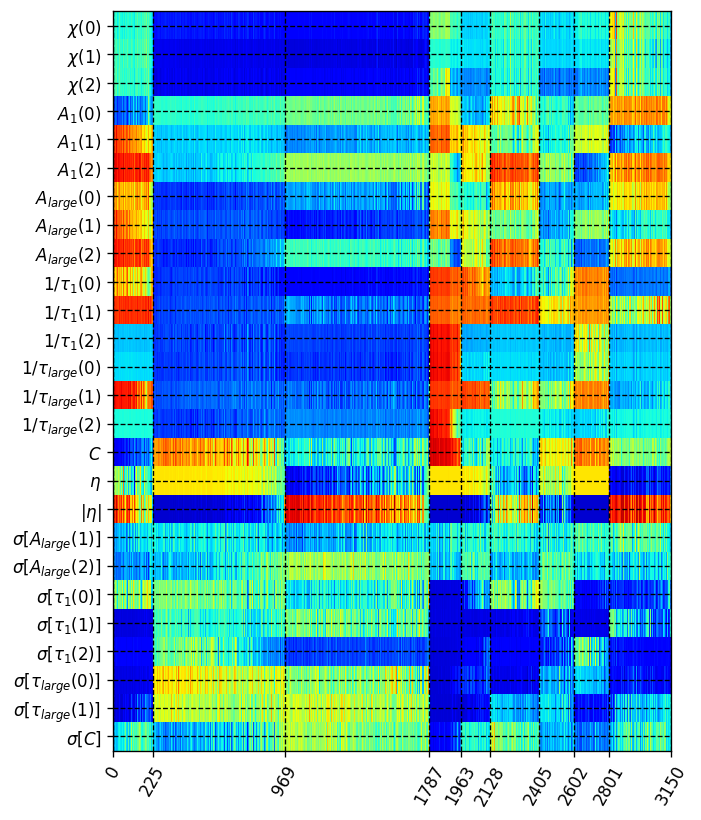

In [114]:
sdata = reordered_data.copy()
for n in range(sdata.shape[0]):
    sdata[n] = savgol_filter(sdata[n], 10, 2)

plt.figure(figsize=(6, 8), dpi=120)
plt.imshow(sdata, aspect='auto', cmap="jet", interpolation="none")
plt.xticks([0] + bds, rotation=60)
plt.yticks(np.arange(len(row_names_p)), labels=mapping(row_names_p))
plt.grid(True, lw=0.8, c='k', linestyle='--')
plt.show()

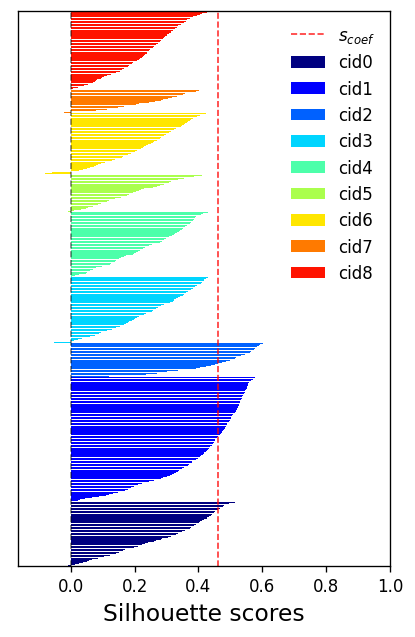

In [29]:
plt.figure(dpi=120, figsize=(4, 6))
pu.draw_silhouette(sval_p, cluster_id_p, scoeff=scoeff_p)
plt.show()

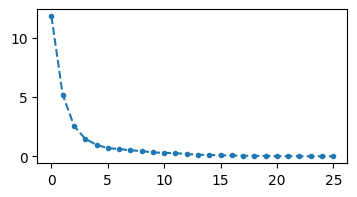

In [118]:
# Dimension reduction with PCA
eigval, eigvec, pca_data, _ = pu.pca(align_data_p)

plt.figure(figsize=(4,2))
plt.plot(eigval, '.--')
plt.show()

In [164]:
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(align_data_p)
H = model.components_

In [165]:
H.shape

(2, 3150)

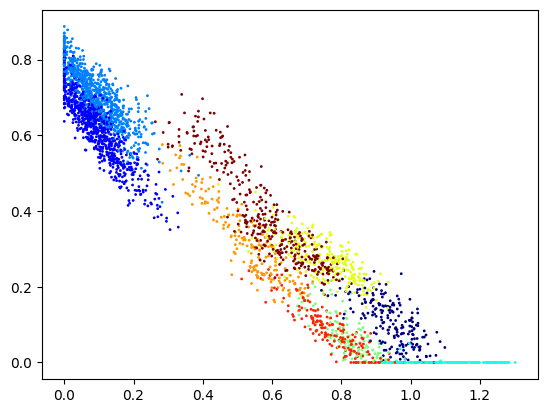

In [167]:
plt.figure()
plt.scatter(H[0], H[1], c=cluster_id_p, s=1, cmap=cmap)
plt.show()

In [154]:
set_seed(1000)
wopt, hopt, df_hist = pu.nnmf_simple(align_data_p, n_features=3, nre=50, nitr=1000, tol=1e-5)
plt.plot(df_hist)

KeyboardInterrupt: 

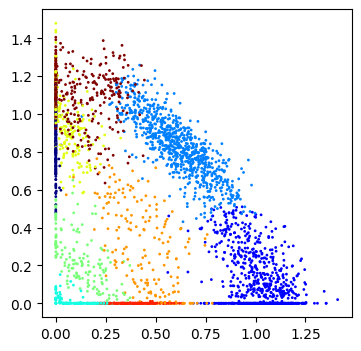

In [153]:
plt.figure(figsize=(4,4))
plt.scatter(hopt[0], hopt[1], c=cluster_id_p, s=1, cmap=cmap)
plt.show()

In [130]:
x0 = align_data_p.T @ eigvec[:, 0]
x1 = align_data_p.T @ eigvec[:, 1]
x2 = align_data_p.T @ eigvec[:, 2]

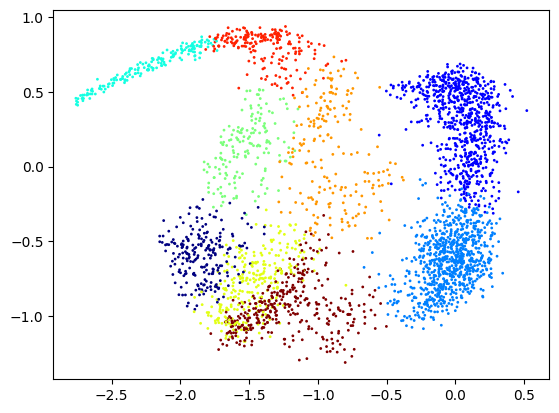

In [142]:
plt.figure()
plt.scatter(x0, x1, c=cluster_id_p, s=1, cmap=cmap)
plt.show()


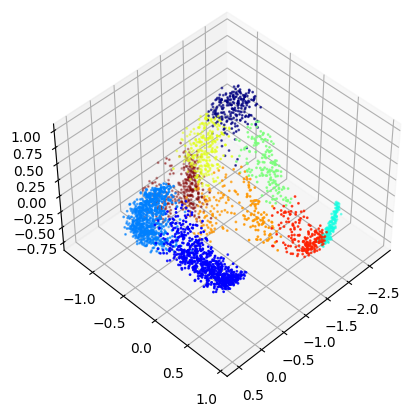

In [141]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(x0, x1, x2, c=cluster_id_p, s=1, cmap=cmap)
ax.view_init(45, 45)
plt.show()

In [ ]:
tag = "nr0np0"
im = construct_square_image(tag, cluster_id_p[np.newaxis, :], col_names)
cmap = plt.get_cmap("jet", num_c)

plt.figure()
cax = plt.imshow(im, vmin=0, vmax=np.max(cluster_id_p), origin="lower", extent=[0, 1, 0, 1], cmap=cmap)
cbar = plt.colorbar(cax, ticks=np.arange(0.5, num_c-0.5, (num_c-1)/num_c))
cbar.set_ticklabels(["%d"%(n+1) for n in range(num_c)])

cbar.set_label("Cluster id", fontsize=14)
plt.title(tag, fontsize=14)

plt.xticks(np.arange(0, 1.1, 0.5))
plt.yticks(np.arange(0, 1.1, 0.25), labels=["0.0", "0.5", "1.0", "1.5", "2.0"])
plt.xlabel(r"$\beta$", fontsize=13)
plt.ylabel(r"$\alpha$", fontsize=13)

plt.show()

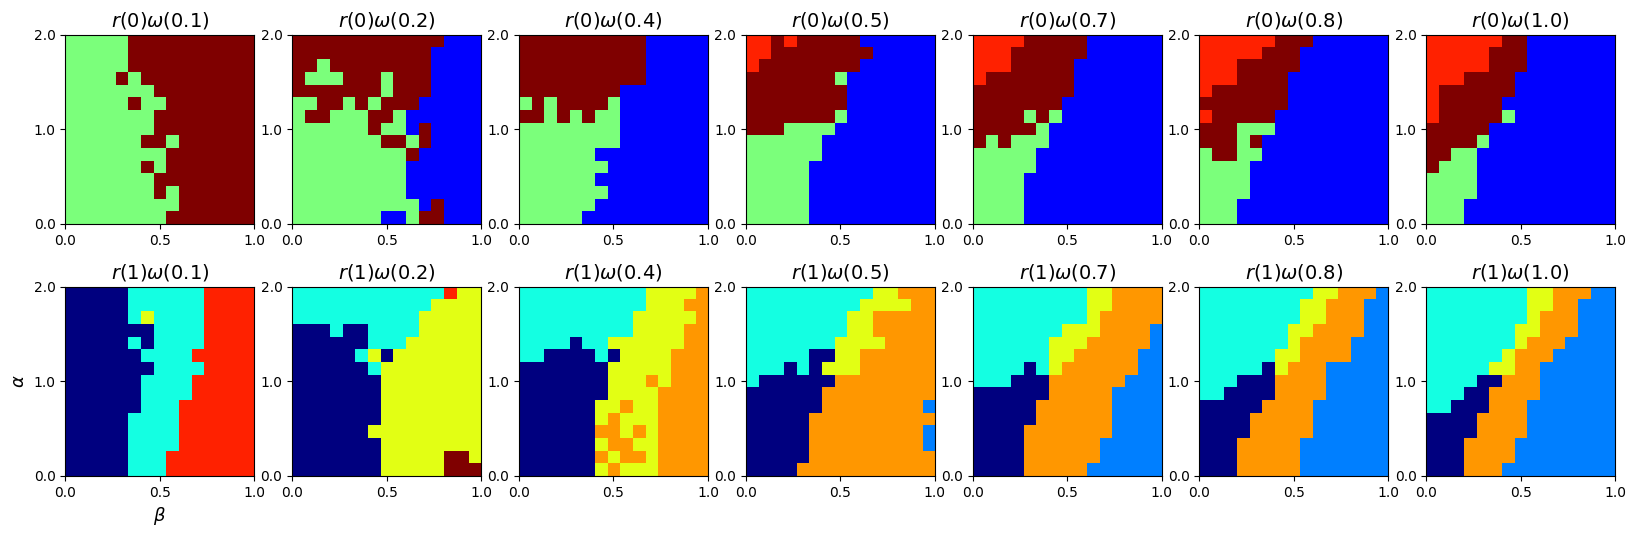

In [30]:
w = np.arange(0.1, 1.01, 0.15)

plt.figure(dpi=100, figsize=(20, 6))
for nr in range(2):
    for nw in range(7):
        plt.subplot(2, 7, nr*7+nw+1)

        im = construct_square_image("nr%dnp%d"%(nr, nw), cluster_id_p[np.newaxis, :], col_names)
        cmap = plt.get_cmap("jet", num_c)

        cax = plt.imshow(im, vmin=0, vmax=np.max(cluster_id_p), origin="lower", extent=[0, 1, 0, 1], cmap=cmap)
        # cbar = plt.colorbar(cax, ticks=np.arange(0.5, num_c-0.5, (num_c-1)/num_c))
        # cbar.set_ticklabels(["%d"%(n+1) for n in range(num_c)])
        # cbar.set_label("Cluster id", fontsize=14)
        plt.title(r"$r(%d)\omega(%.1f)$"%(nr, w[nw]), fontsize=14)
        plt.xticks([0, 0.5, 1])
        plt.yticks([0, 0.5, 1], labels=["0.0", "1.0", "2.0"])

        if nr == 1 and nw == 0:
            plt.xlabel(r"$\beta$", fontsize=13)
            plt.ylabel(r"$\alpha$", fontsize=13)


        # plt.xticks(np.arange(0, 1.1, 0.5))
        # plt.yticks(np.arange(0, 1.1, 0.25), labels=["0.0", "0.5", "1.0", "1.5", "2.0"])
        # plt.xlabel(r"$\beta$", fontsize=13)
        # plt.ylabel(r"$\alpha$", fontsize=13)

plt.show()

#### Similarity measure

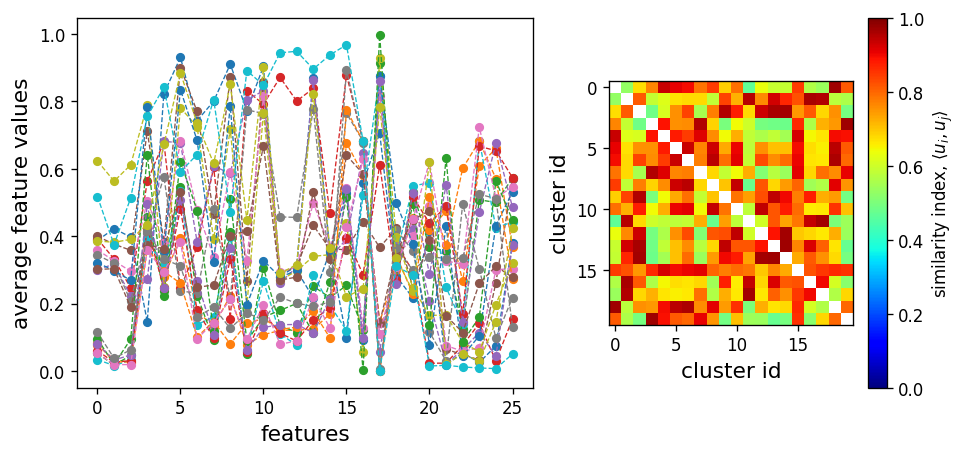

In [110]:
props = []

bd_ = [0] + bds
for cid in range(num_c):
    im_sub = reordered_data[:, bd_[cid]:bd_[cid+1]]
    props.append(np.average(im_sub, axis=1))
    
    
    
fig, axs = plt.subplots(1, 2, figsize=(9, 4), dpi=120, gridspec_kw={"width_ratios": [0.6, 0.4]})

plt.axes(axs[0])
for y in props:
    plt.plot(y, '.--', lw=0.8, ms=9)
plt.ylabel("average feature values", fontsize=13)
plt.xlabel("features", fontsize=13)

plt.axes(axs[1])

def norm(x):
    return np.sqrt(np.sum(x**2))

num_props = len(props)
im = np.zeros([num_props, num_props])
for i in range(num_props):
    for j in range(i+1, num_props):
        im[i, j] = np.dot(props[i], props[j]) / norm(props[i]) / norm(props[j])
        im[j, i] = im[i, j]
    im[i, i] = np.nan
    
plt.imshow(im, cmap="jet", vmax=1, vmin=0)
cbar = plt.colorbar()
cbar.set_label(r"similarity index, $\leftangle u_{i}, u_{j} \rightangle$")
plt.xlabel("cluster id", fontsize=13)
plt.ylabel("cluster id", fontsize=13)

plt.show()

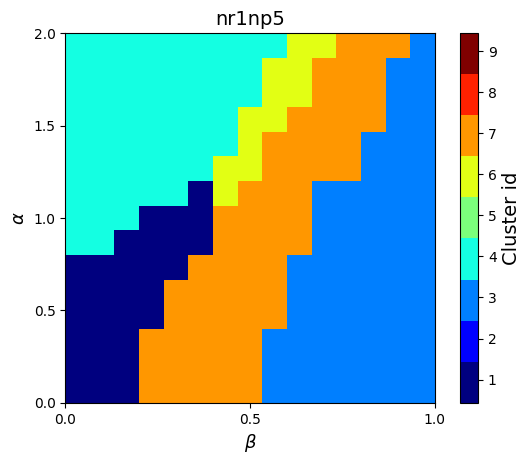

In [438]:
tag = "nr1np5"

im = construct_square_image("nr1np5", cluster_id_p[np.newaxis, :], col_names)
cmap = plt.get_cmap("jet", num_c)

plt.figure()
cax = plt.imshow(im, vmin=0, vmax=np.max(cluster_id_p), origin="lower", extent=[0, 1, 0, 1], cmap=cmap)
cbar = plt.colorbar(cax, ticks=np.arange(0.5, num_c-0.5, (num_c-1)/num_c))
cbar.set_ticklabels(["%d"%(n+1) for n in range(num_c)])

cbar.set_label("Cluster id", fontsize=14)
plt.title(tag, fontsize=14)

plt.xticks(np.arange(0, 1.1, 0.5))
plt.yticks(np.arange(0, 1.1, 0.25), labels=["0.0", "0.5", "1.0", "1.5", "2.0"])
plt.xlabel(r"$\beta$", fontsize=13)
plt.ylabel(r"$\alpha$", fontsize=13)

plt.show()

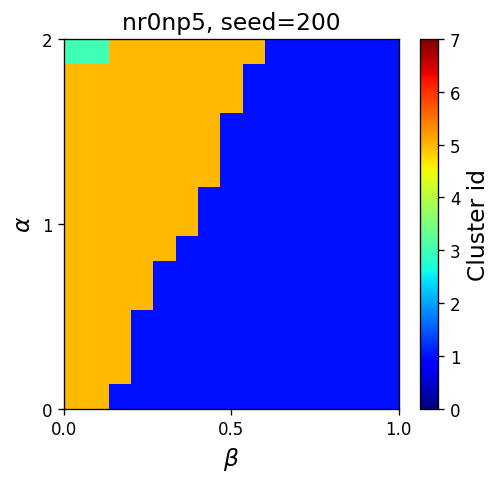

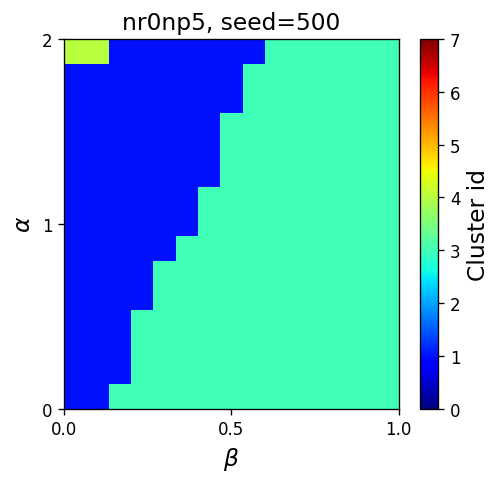

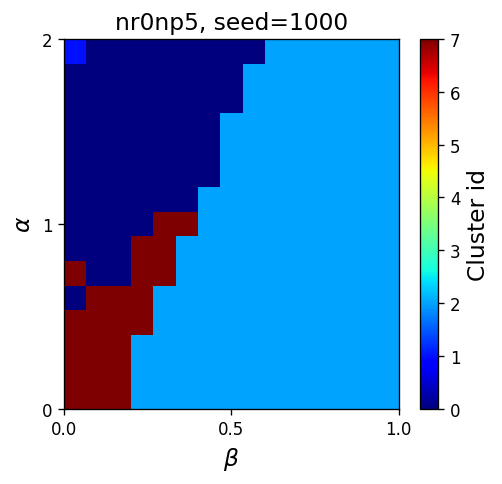

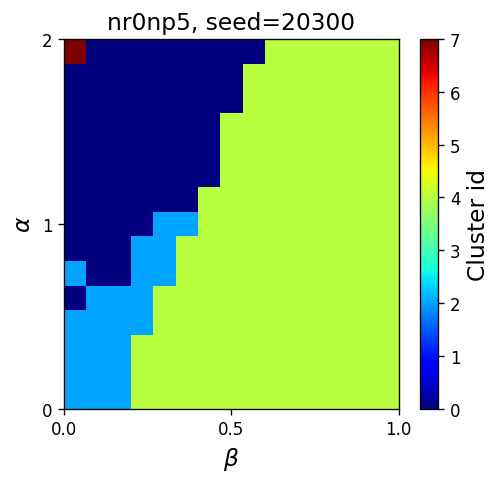

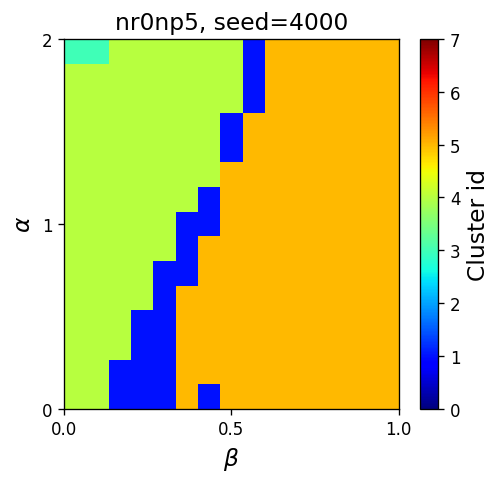

In [ ]:
## Comparison clusters with different seed
# seed_set = [200, 500, 1000, 20300, 4000]
seed_set = [200, 500, 1000, 20300, 4000]
km_seed_set = []
sval_seed_set = []
scoef_seed_set = []
num_clusters = 8

tag = "nr0np5"

for seed in seed_set:
    np.random.seed(seed)

    km_obj = KMeans(n_clusters=num_clusters, init="k-means++", n_init="auto")
    km_obj.fit(align_data.T)
    labels = km_obj.predict(align_data.T)
    sval, scoeff = get_silhouette_scores(align_data, labels)

    # im = construct_square_image(tag, cluster_ids[np.newaxis, :], col_names)

    km_seed_set.append(km_obj)
    sval_seed_set.append(scoeff)
    scoef_seed_set.append(sval)


    im = construct_square_image(tag, labels[np.newaxis, :], col_names)
    plt.figure(figsize=(4.5, 4), dpi=120)
    plt.imshow(im, vmin=0, vmax=np.max(cluster_ids), origin="lower", extent=[0, 1, 0, 2], aspect="auto", cmap="jet")
    cbar = plt.colorbar(ticks=np.arange(num_clusters))
    cbar.set_label("Cluster id", fontsize=14)
    plt.title(tag + ", seed=%d"%(seed), fontsize=14)
    plt.xticks([0, 0.5, 1])
    plt.yticks([0, 1, 2])
    plt.xlabel(r"$\beta$", fontsize=14)
    plt.ylabel(r"$\alpha$", fontsize=14)
    plt.show()

In [24]:
cid0 = km_seed_set[0].predict(align_data.T)
cid1 = km_seed_set[1].predict(align_data.T)


im0 = construct_square_image(tag, cid0[np.newaxis, :], col_names)
im1 = construct_square_image(tag, cid1[np.newaxis, :], col_names)

In [290]:
im_test = im.copy()

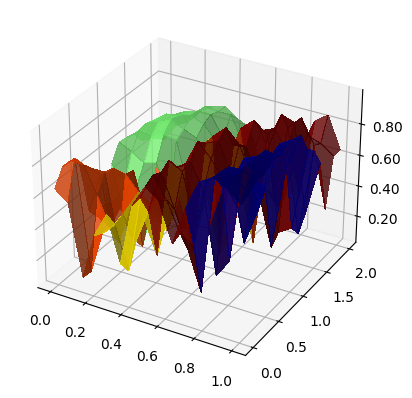

In [282]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

tag = "nr1np5"
alpha = s_vals[nc]
alpha = (alpha - np.min(alpha)) / (np.max(alpha) - np.min(alpha))

im = construct_square_image(tag, cluster_ids[np.newaxis, :], col_names)
alpha = construct_square_image(tag, alpha[np.newaxis, :], col_names)
im = (im - np.min(im)) / (np.max(im) - np.min(im))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
x = np.linspace(0, 1, 15)
y = np.linspace(0., 2, 15)
x2, y2 = np.meshgrid(x, y)

# Plot the surface.
palette = get_palette("jet")
cmap = palette(im)
surf = ax.plot_surface(x2, y2, alpha, facecolors=cmap,
                       linewidth=0, antialiased=False, alpha=0.8)
ax.zaxis.set_major_formatter('{x:.02f}')


plt.show()

(1,)

In [41]:
props = []

bd_ = [0] + bds
for cid in range(num_clusters[nc]):
    im_sub = reordered_data[:, bd_[cid]:bd_[cid+1]]
    props.append(np.average(im_sub, axis=1))


In [60]:
np.unique(im)

array([0., 2., 4., 5., 7.])

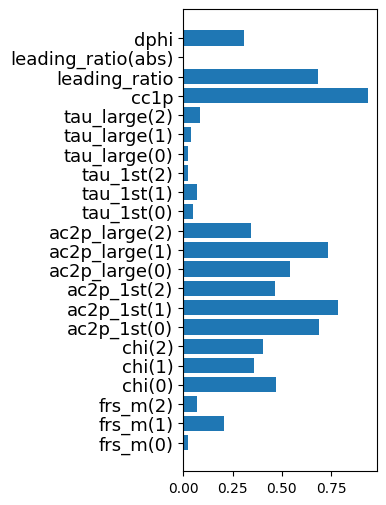

In [64]:
plt.figure(figsize=(2.5, 6))
# plt.plot(props[0], '.--', ms=10, lw=1)
nr = len(row_names)

plt.barh(np.arange(nr), props[7])
plt.yticks(np.arange(nr), labels=row_names, rotation=0, fontsize=13)
plt.show()

In [65]:
props[7]

array([2.65152095e-02, 2.05416534e-01, 7.19949037e-02, 4.70133023e-01,
       3.58681095e-01, 4.06548665e-01, 6.86319386e-01, 7.84426349e-01,
       4.62987052e-01, 5.42287657e-01, 7.33973874e-01, 3.41596062e-01,
       4.88075799e-02, 7.10805287e-02, 2.42947669e-02, 2.58988207e-02,
       3.86878560e-02, 8.30279283e-02, 9.35464353e-01, 6.81934732e-01,
       1.70940171e-04, 3.08784022e-01])

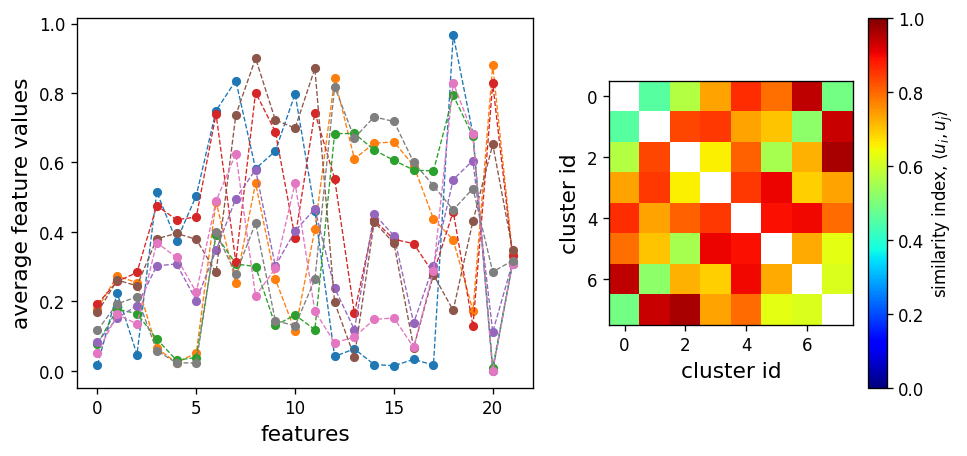

In [220]:
# plt.figure(figsize=(6, 4), dpi=120, )
fig, axs = plt.subplots(1, 2, figsize=(9, 4), dpi=120, gridspec_kw={"width_ratios": [0.6, 0.4]})

plt.axes(axs[0])
for y in props:
    plt.plot(y, '.--', lw=0.8, ms=9)
plt.ylabel("average feature values", fontsize=13)
plt.xlabel("features", fontsize=13)

plt.axes(axs[1])

def norm(x):
    return np.sqrt(np.sum(x**2))

num_props = len(props)
im = np.zeros([num_props, num_props])
for i in range(num_props):
    for j in range(i+1, num_props):
        im[i, j] = np.dot(props[i], props[j]) / norm(props[i]) / norm(props[j])
        im[j, i] = im[i, j]
    im[i, i] = np.nan
    
plt.imshow(im, cmap="jet", vmax=1, vmin=0)
cbar = plt.colorbar()
cbar.set_label(r"similarity index, $\leftangle u_{i}, u_{j} \rightangle$")
plt.xlabel("cluster id", fontsize=13)
plt.ylabel("cluster id", fontsize=13)

plt.show()

# Check dynamics

In [288]:
import sys

sys.path.append("../include/")
import hhtools
import hhsignal

In [289]:
obj = hhtools.SummaryLoader("./asym_link_full/")
print(obj.summary["chi"].shape)
print(obj.controls.keys())

# correction
obj.summary["chi"][:,:,:,:,24:48,0] = np.nan

(15, 15, 2, 7, 72, 3)
dict_keys(['alpha_set', 'beta_set', 'id_rank', 'p_ratio_set'])


In [327]:
def draw_quadratic_summary(data, fname=None, xl_raster=(1500, 2500), nsamples=20, wbin_t=1, fs=2000, shuffle=False):
    
    from tqdm.notebook import tqdm
    from scipy.ndimage import gaussian_filter1d
    
    teq = 0.5
    
    plt.figure(dpi=100, figsize=(9, 12))
    plt.axes([0.1, 0.8, 0.8, 0.15])
    
    seq = np.arange(len(data["step_spk"]))
    cr = [800, 1000, 1800, 2000]
    cs = ["r", "b", "deeppink", "navy"]
    
    if shuffle:
        np.random.shuffle(seq)
        cr = None
        cs = None
        
    
    hhtools.draw_spk(data["step_spk"], color_ranges=cr, colors=cs, xl=xl_raster, sequence=seq)
    plt.ylabel("# neuron", fontsize=14)
    plt.xlabel("Time (ms)", fontsize=14)
    
    title = "nid: %d"%(data["nid"][0])
    for n in data["nid"][1:]:
        title += ",%d"%(n)
    plt.title(title, fontsize=14)

    plt.twinx()
    t = data["ts"] * 1e3
    plt.plot(t, data["vlfp"][0], c='k', zorder=10, label=r"$V_T$")
    plt.plot(t, data["vlfp"][1], c='b', lw=1, label=r"$V_F$")
    plt.plot(t, data["vlfp"][2], c='r', lw=1, label=r"$V_S$")
    plt.legend(fontsize=14, loc="upper left", ncol=3, edgecolor="none")
    plt.ylabel("V", fontsize=14)
    
    # ----------------- Generate AC for x -----------------#
    t0_set = np.random.uniform(low=teq, high=data["ts"][-1]-wbin_t, size=nsamples)
    cc_set = [[] for _ in range(4)]
    for t0 in tqdm(t0_set):
        n0 = int(t0 * fs)
        n1 = n0 + wbin_t * fs

        for i in range(4):
            if i < 3:
                x = data["vlfp"][i][n0:n1]
                y = x.copy()
            else:
                x = data["vlfp"][1][n0:n1]
                y = data["vlfp"][2][n0:n1]

            cc, tlag = hhsignal.get_correlation(x, y, fs, max_lag=0.1)
            cc_set[i].append(cc)

    cc_set_avg = np.average(cc_set, axis=1)
    cc_set_std = np.std(cc_set, axis=1)
    
    # ----------------- Draw AC for x -----------------#
    labels = ["AC(T)", "AC(F)", "AC(S)", "CC(F, S)"]
    yl = [-0.8, 1.1]

    for n in range(4):
        # plt.subplot(1, 4, n+1)
        plt.axes([0.1+0.22*n, 0.6, 0.15, 0.15])
        plt.plot([0, 0], yl, 'g--', lw=1)
        plt.plot([-0.1, 0.1], [0, 0], 'g--', lw=1)
        plt.plot(tlag, cc_set_avg[n], c='k')
        plt.fill_between(tlag, cc_set_avg[n]-cc_set_std[n]/2, cc_set_avg[n]+cc_set_std[n]/2, alpha=0.5, color='k', edgecolor="none")
        plt.xlim([-0.1, 0.1])
        plt.xlabel(r"$\Delta t$ (s)", fontsize=14)
        plt.title(labels[n], fontsize=14)
        plt.ylim(yl)
        if n == 3:
            plt.text(-0.06, -0.7, r"$V_F$ lead", horizontalalignment="center")
            plt.text(0.06, -0.7, r"$V_S$ lead", horizontalalignment="center")
        
    # ----------------- Draw figure -----------------#
    tags = ["T", "F", "S"]
    xt = np.arange(0.5, 4.1, 0.5)
    fl = [20, 80]
    
    for nid in range(3):

        psd, ff, tf = hhsignal.get_stfft(data["vlfp"][nid], data["ts"], 2000, frange=[2, 100])
        yf, f = hhsignal.get_fft(data["vlfp"][nid], 2000, frange=[2, 100])

        plt.axes([0.1, 0.4-0.17*nid, 0.7, 0.15])
        hhtools.imshow_xy(psd, x=tf, y=ff, cmap="jet", interpolation="spline16")
        plt.ylabel("frequency (%s) (Hz)"%(tags[nid]), fontsize=14)
        plt.ylim(fl)
        plt.colorbar()

        if nid < 2:
            plt.xticks(xt, labels=["" for _ in xt])
        else:
            plt.xticks(xt)
            plt.xlabel("Time (s)", fontsize=14)

        plt.axes([0.8, 0.4-0.17*nid, 0.11, 0.15])
        yf_s = gaussian_filter1d(yf, 3)
        plt.plot(yf, f, c='k')
        plt.plot(yf_s, f, c='r', lw=1.5)
        plt.xlabel(r"FFT($V_{%s}$)"%(tags[nid]), fontsize=14)
        plt.ylim(fl)
        
    if fname is not None:
        plt.savefig(fname, dpi=150)
    
    plt.show()

In [331]:
cluster_exist

array([0., 3., 4., 5., 6.])

In [332]:
nc

13

nr1np5
[0. 3. 4. 5. 6.]
6.0


  0%|          | 0/20 [00:00<?, ?it/s]

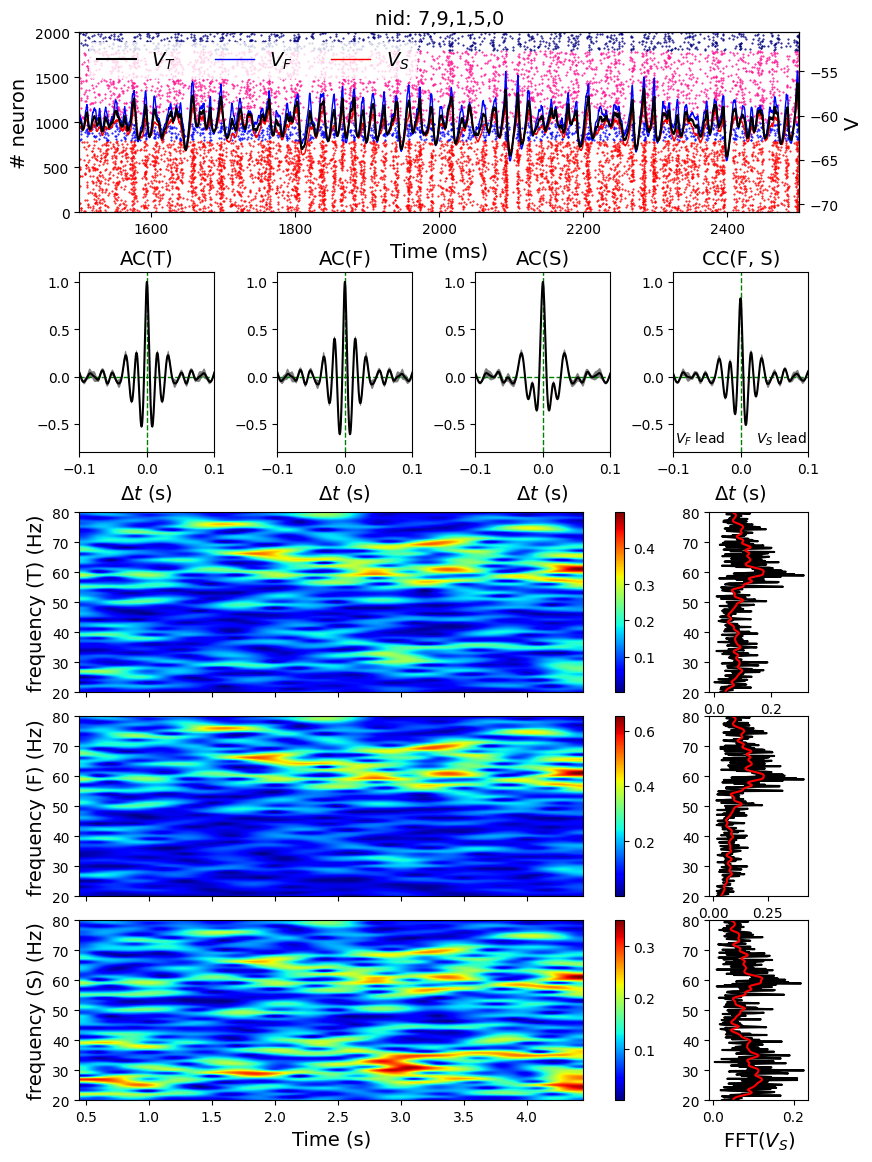

  0%|          | 0/20 [00:00<?, ?it/s]

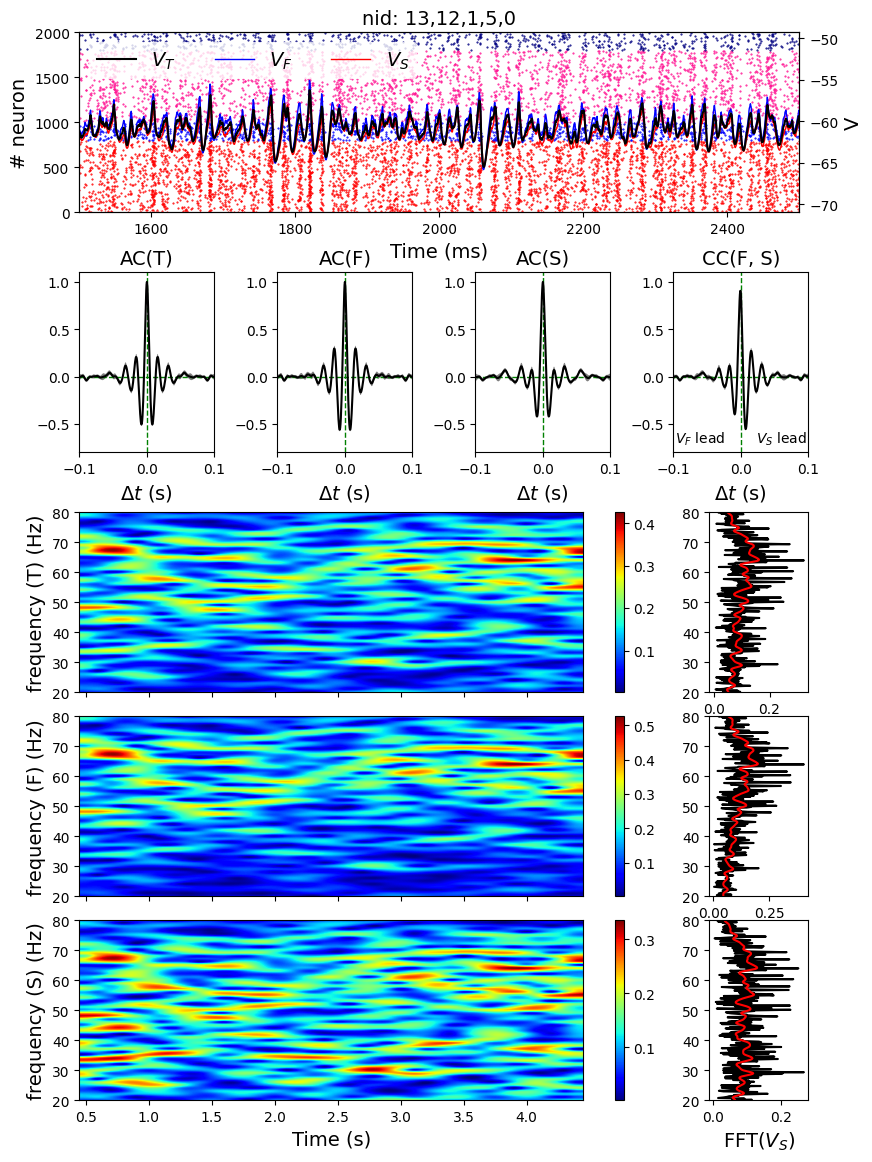

  0%|          | 0/20 [00:00<?, ?it/s]

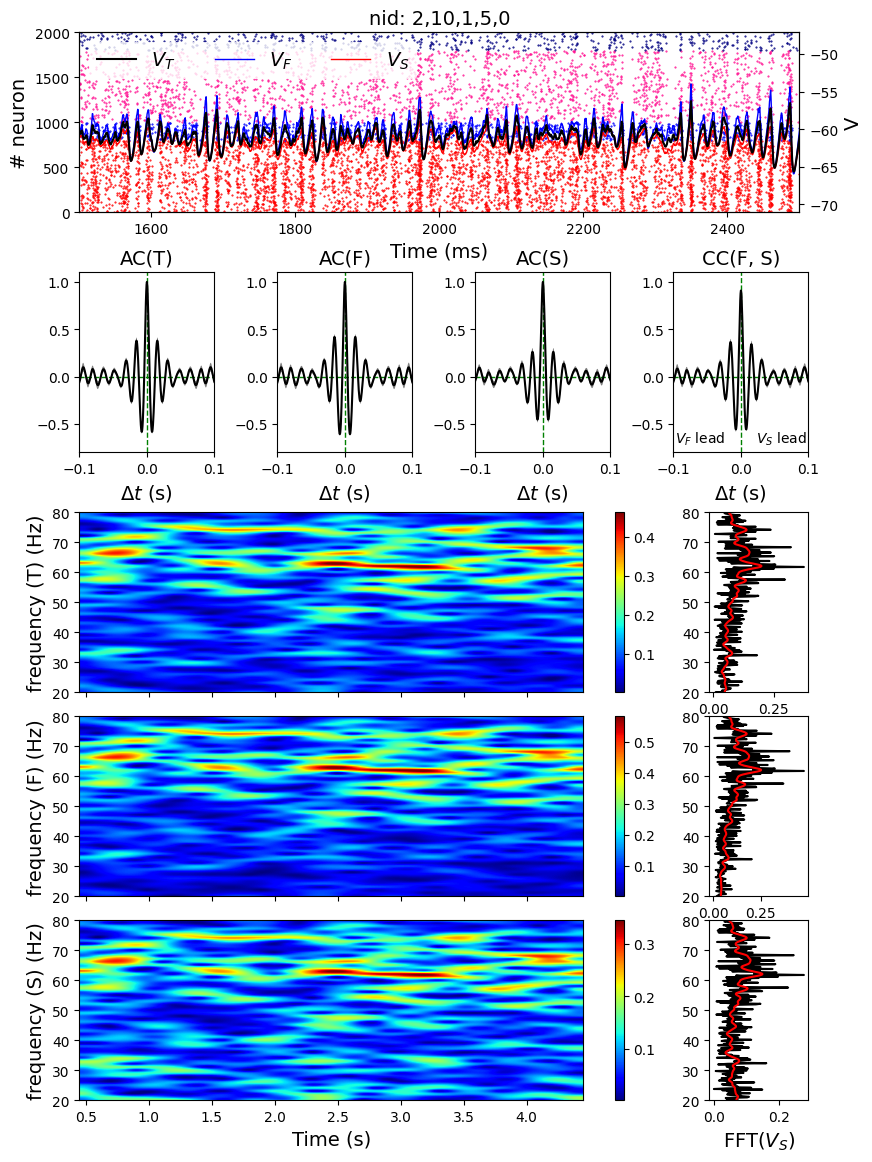

In [336]:
## Use above result (temporaly): tag, im (cluster id), alpha
print(tag)

cluster_exist = np.unique(im)
print(cluster_exist)
# inds = np.arange(alpha.shape[0] * alpha.shape[1]).reshape(alpha.shape)

nc = cluster_exist[4]
print(nc)
# get best, middle, worst
a_flat = alpha.flatten()

idc = np.where(im.flatten() == nc)[0]
s_order = alpha.flatten()[idc]
idc_o = np.argsort(s_order)[::-1]

idc = idc[idc_o]

n_tracks = [idc[0] ,idc[len(idc)//2], idc[-1]]
for n in n_tracks:
    nrow, ncol = n//15, n%15

    # pick
    data = obj.load_detail(nrow, ncol, 1, 5, 0)
    draw_quadratic_summary(data, fname=None)




In [322]:
alpha.flatten()[idc]

array([0.99636201, 0.99548886, 0.99112991, 0.98804693, 0.98756682,
       0.98666175, 0.98496192, 0.98360523, 0.98327453, 0.9792314 ,
       0.97833078, 0.97628708, 0.96744481, 0.95263245, 0.9487617 ,
       0.94607421, 0.94442787, 0.94169687, 0.94025593, 0.91981048,
       0.90739252, 0.90370422, 0.90023507, 0.89905128, 0.88144082,
       0.85325302, 0.83825909, 0.8013529 , 0.78852299, 0.76573528,
       0.76067225, 0.68544476, 0.64457444, 0.57425762, 0.54291327,
       0.51677612, 0.49502517, 0.34979843, 0.32932512, 0.31199845,
       0.25032038])

In [324]:
print(alpha[0, 12])

0.996362007696438


In [318]:
n_tracks

[12, 26, 163]

In [316]:
inds.shape

(15, 15)

array([ 12, 104, 119,  27,  58,  73,  43,  74,  28,  88,  42, 134,  89,
        13,  72,  11,  44, 118,  59, 103,  26,  29,  57,  41,  14, 149,
        87, 164,  56,  10, 133, 179, 117,  86, 102,  55,  25, 194, 148,
       101, 163])

In [309]:
s_order.shape

(41,)

In [306]:
idc

array([ 10,  11,  12,  13,  14,  25,  26,  27,  28,  29,  41,  42,  43,
        44,  55,  56,  57,  58,  59,  72,  73,  74,  86,  87,  88,  89,
       101, 102, 103, 104, 117, 118, 119, 133, 134, 148, 149, 163, 164,
       179, 194])

In [304]:
print(inds.flatten())

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224]


In [ ]:
## Quantization
num_clusters = np.arange(2, 15)

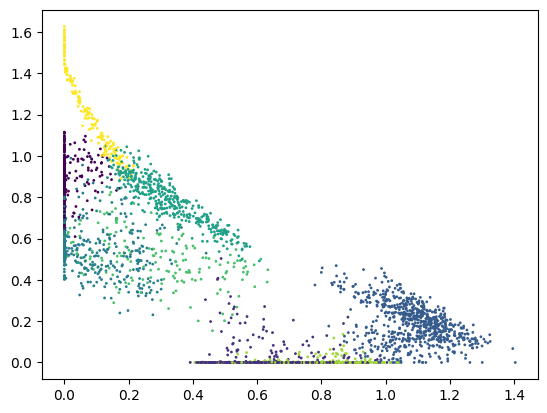

In [117]:
num_c = 8
km_obj = KMeans(n_clusters=num_c, init="k-means++", n_init="auto")
km_obj.fit(align_data.T)
cluster_ids = km_obj.predict(align_data.T)

plt.figure()
plt.scatter(Hopt[0], Hopt[1], c=cluster_ids, s=1)
plt.show()

In [25]:
sval, scoeff = get_silhouette_scores(align_data, cluster_ids)
reordered_data, id_sort, bds = reorder_data(align_data, cluster_ids, sval)

[0, 1, 2, 3, 4, 5, 6, 7]


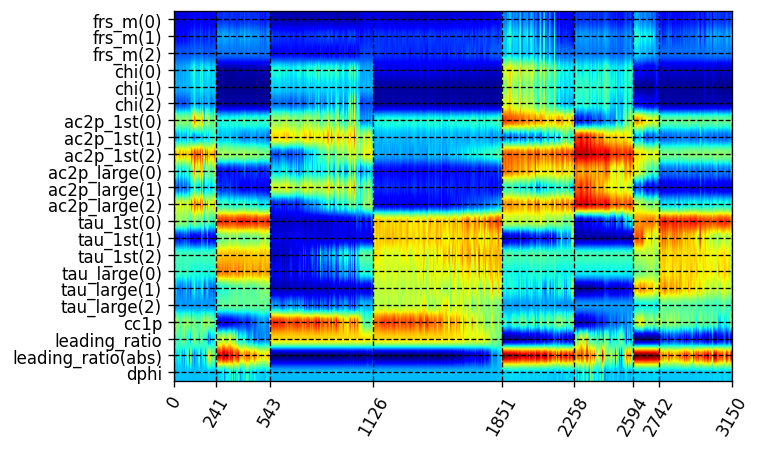

In [26]:
# draw sval in ordered manner

plt.figure(figsize=(6, 4), dpi=120)
plt.imshow(reordered_data, aspect='auto', cmap="jet")
plt.xticks([0] + bds, rotation=60)
plt.yticks(np.arange(len(row_names)), labels=row_names)
plt.grid(True, lw=0.8, c='k', linestyle='--')
plt.show()

In [88]:
im = construct_square_image("nr2np0", cluster_ids[np.newaxis, :], col_names)

plt.figure()
plt.imshow(im, vmin=0, vmax=np.max(cluster_ids), origin="lower")
plt.colorbar(ticks=np.arange(5))
plt.show()

ValueError: nr2np0 does not exist in col_names

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(Hopt[0], Hopt[1], c=cluster_ids, cmap='jet', s=2)

In [1]:
align_data

NameError: name 'align_data' is not defined

### DBSCAN

DBSCAN(eps=2)

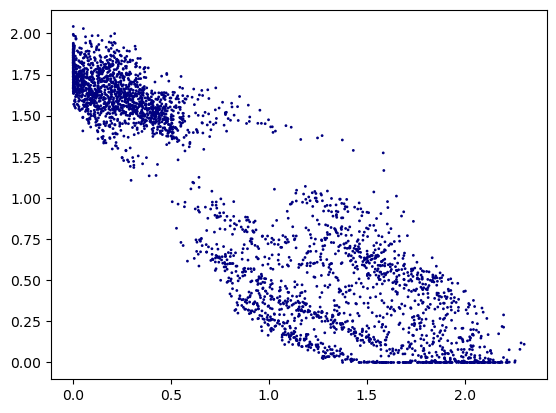

In [110]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=2, min_samples=5, metric="euclidean")
db = model.fit(Hopt.T)
cluster_dbscan= db.labels_

plt.figure()
plt.scatter(Hopt[0], Hopt[1], c=cluster_dbscan, cmap="jet", s=1)
plt.show()

In [160]:
from sklearn.cluster import OPTICS

cluster_optics = OPTICS(cluster_method="xi", xi=0.1, min_cluster_size=20)
# cluster_optics = OPTICS(cluster_method="db s", xi=0.05, min_cluster_size=20)
cluster_optics.fit(Hopt.T)
cluster_opt = cluster_optics.labels_

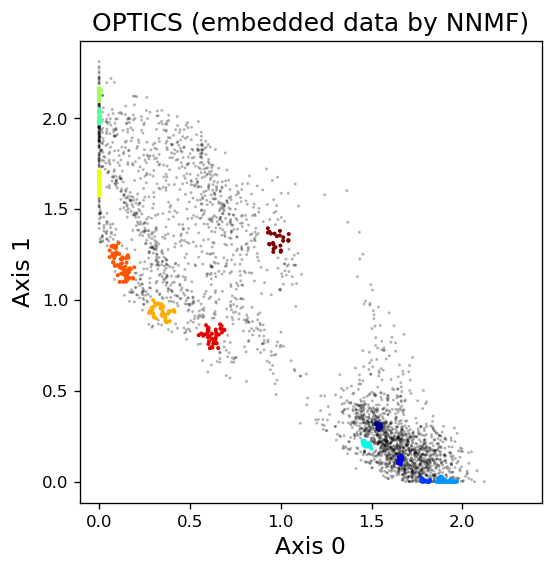

In [161]:
plt.figure(figsize=(5, 5), dpi=120)
is_null = cluster_opt == -1
plt.scatter(Hopt[0][is_null], Hopt[1][is_null], c='k', alpha=0.3, s=3, edgecolors="none")
plt.scatter(Hopt[0][~is_null], Hopt[1][~is_null], c=cluster_opt[~is_null], alpha=1, s=2, cmap="jet")
plt.xlabel("Axis 0", fontsize=14)
plt.ylabel("Axis 1", fontsize=14)
plt.title("OPTICS (embedded data by NNMF)", fontsize=15)
plt.axis("square")
plt.show()

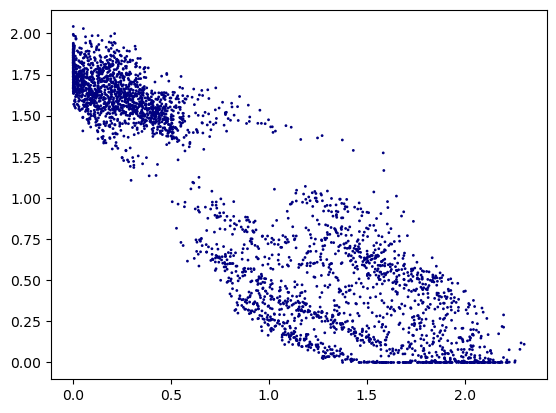

In [ ]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=2, min_samples=5, metric="euclidean")
db = model.fit(Hopt.T)
cluster_dbscan= db.labels_

plt.figure()
plt.scatter(Hopt[0], Hopt[1], c=cluster_dbscan, cmap="jet", s=1)
plt.show()

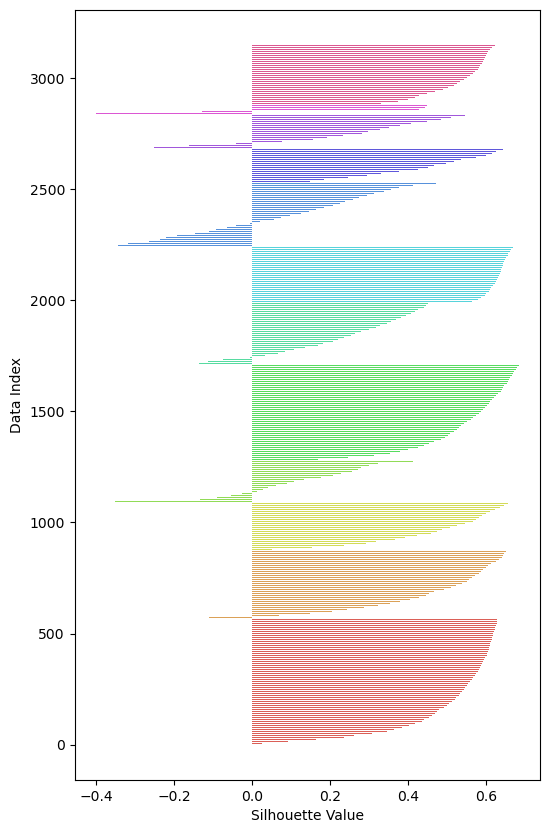

In [66]:
import seaborn as sns
 
## 각 클러스터별로 Silhouette(실루엣) 값을 정렬한다.
uniq_labels = np.unique(cluster.labels_)
sorted_cluster_svl = []
rearr_labels = []
for ul in uniq_labels:
    labels_idx = np.where(cluster.labels_==ul)[0]
    target_svl = val[labels_idx]
    sorted_cluster_svl += sorted(target_svl)
    rearr_labels += [ul]*len(target_svl)
 
colors = sns.color_palette('hls', len(uniq_labels))
color_labels = [colors[i] for i in rearr_labels]
 
fig = plt.figure(figsize=(6, 10))
fig.set_facecolor('white')
plt.barh(range(len(sorted_cluster_svl)), sorted_cluster_svl, color=color_labels)
plt.ylabel('Data Index')
plt.xlabel('Silhouette Value')
plt.show()

In [54]:
len(val)

3150

In [23]:
Hopt.shape

(2, 3150)

## Hierarchical clustering

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage

align_data, row_names, col_names = concat_data(post_data, key_to_rm=["cv", "dphi", "leading_ratio", "leading_ratio (abs)"])
print(align_data.shape)

cv passed
dphi passed
(21, 3150)
nrow: 21, ncol: 3150
inversing target keys: ['tau_1st(0)', 'tau_1st(1)', 'tau_1st(2)', 'tau_large(0)', 'tau_large(1)', 'tau_large(2)']
(21, 3150)


In [ ]:
align_data, row_names, col_names = concat_data(post_data, key_to_rm=["cv", "dphi"])
print(align_data.shape)

c:\Users\jungyoung\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
c:\Users\jungyoung\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Text(0, 0.5, 'NMF Component 2')

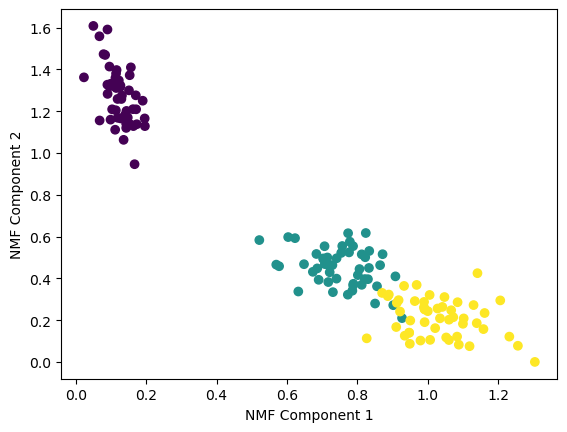

In [520]:
from sklearn.decomposition import NMF
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

iris = load_iris()
iris_ftrs = iris.data
nmf = NMF(n_components=2)
nmf.fit(iris_ftrs)
iris_nmf = nmf.transform(iris_ftrs)
plt.scatter(x=iris_nmf[:,0], y= iris_nmf[:,1], c= iris.target)
plt.xlabel('NMF Component 1')
plt.ylabel('NMF Component 2')

In [519]:
print(np.std(data_ldim[0]), np.std(xy[0]))

0.9357762799053149 0.07420251462531184


In [493]:
np.std(xy[1, :])

0.061442173045969724

(2, 1000)

In [458]:
tmp = np.dot(W, H)

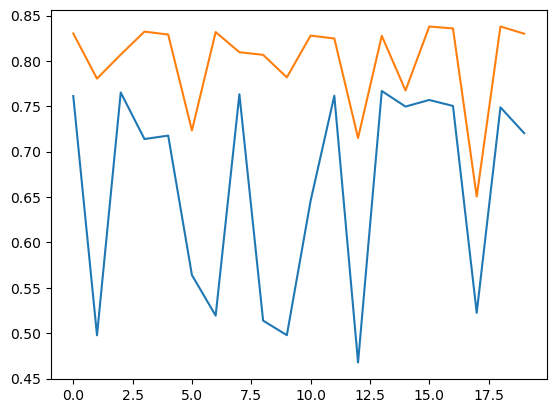

In [461]:
plt.plot(pdata[:, 0])
plt.plot(tmp[:, 0])

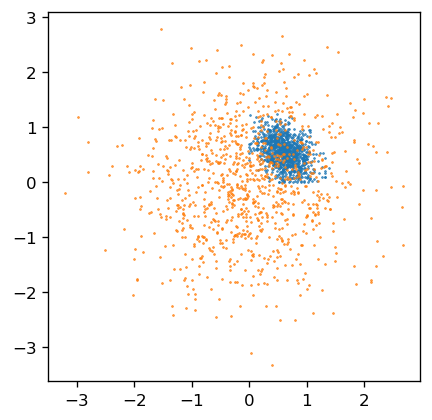

In [508]:
plt.figure(dpi=120, figsize=(4, 4))
plt.plot(H[0], H[1], '.', ms=1)
plt.plot(data_ldim[0], data_ldim[1], '.', ms=1)
plt.show()

In [410]:
print(H.shape, grad_h.shape)

(2, 1000) (2, 1000)


# clustering

In [291]:
# clustering
import sklearn.cluster as clusters

def get_palette(cmap="jet"):
    from matplotlib.cm import get_cmap
    return get_cmap(cmap)

In [292]:
cluster_optics = clusters.OPTICS(xi=0.05, min_cluster_size=20)
cluster_optics.fit(data_embedded)

OPTICS(min_cluster_size=20)

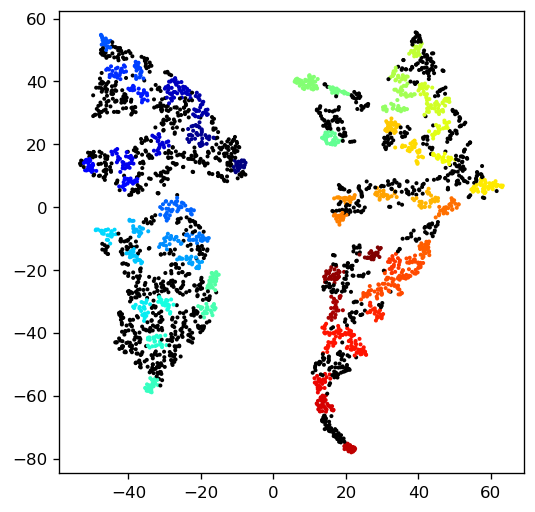

In [293]:
cmap = get_palette("jet")
max_clusters = np.max(cluster_optics.labels_)
cs = []
for lb in cluster_optics.labels_:
    if lb == -1:
        cs.append([0,0,0])
    else:
        cs.append(cmap(lb/max_clusters)[:3])

plt.figure(figsize=(5,5), dpi=120)
plt.scatter(data_embedded[:, 0], data_embedded[:, 1], c=cs, s=2)
plt.show()

In [294]:
labels_200 = clusters.cluster_optics_dbscan(
    reachability=cluster_optics.reachability_,
    core_distances=cluster_optics.core_distances_,
    ordering=cluster_optics.ordering_,
    eps=2.1,
)

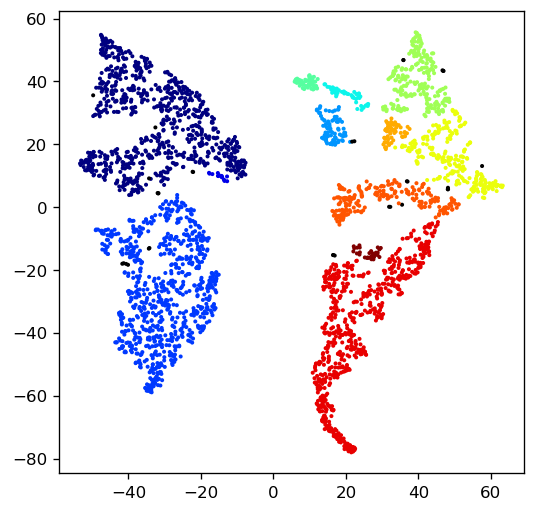

In [295]:
cmap = get_palette("jet")
max_clusters = np.max(labels_200)
cs = []
for lb in labels_200:
    if lb == -1:
        cs.append([0,0,0])
    else:
        cs.append(cmap(lb/max_clusters)[:3])

plt.figure(figsize=(5,5), dpi=120)
plt.scatter(data_embedded[:, 0], data_embedded[:, 1], c=cs, s=2)
plt.show()

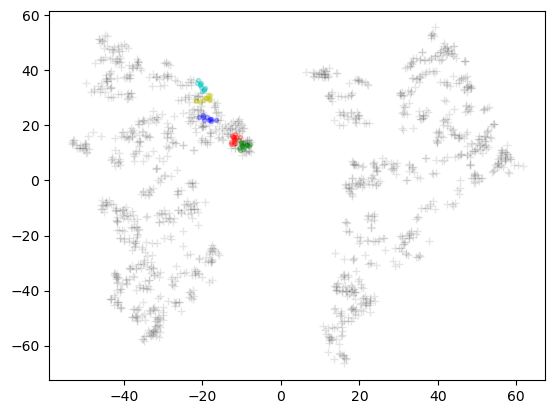

In [245]:
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = data_embedded[cluster_optics.labels_ == klass]
    plt.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
plt.plot(data_embedded[cluster_optics.labels_ == -1, 0], data_embedded[cluster_optics.labels_ == -1, 1], "k+", alpha=0.1)
# ax2.set_title("Automatic Clustering\nOPTICS")

In [213]:
wcss = []
num_clusters = np.arange(1, 20)

for n in num_clusters:
    kmeans = KMeans(n_clusters=n, init = 'k-means++', 
                random_state = 42)
    kmeans.fit(data_embedded)
    wcss.append(kmeans.inertia_)
wcss = np.array(wcss)
dw = wcss[1:] - wcss[:-1]
dw2 = dw[1:] - dw[:-1]

c:\Users\jungyoung\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(


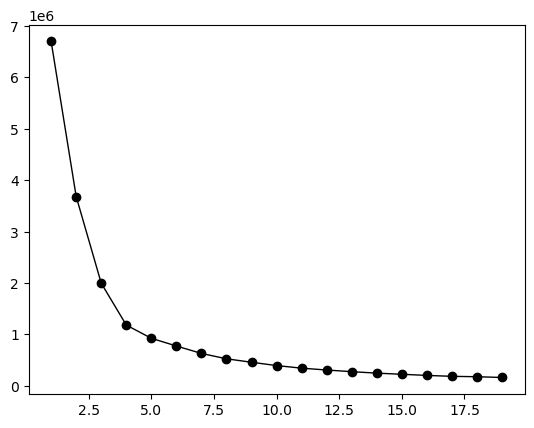

In [214]:
plt.figure()
plt.plot(num_clusters, wcss, 'k.-', ms=12, lw=1)
plt.show()

In [221]:
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=4)
Kmean.fit(data_embedded)
y_pred = Kmean.predict(data_embedded)

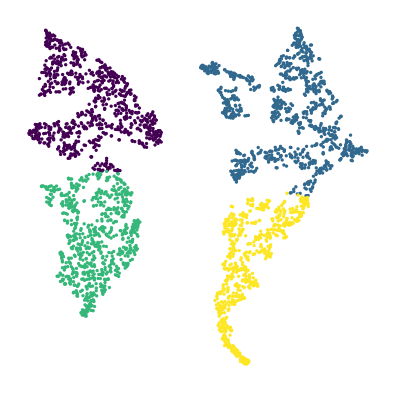

In [222]:
plt.figure(figsize=(4, 4), dpi=120)
plt.scatter(data_embedded[:, 0], data_embedded[:, 1], s=1, c=y_pred)
plt.axis("off")
plt.show()